# EDA zbioru Unraveled (DAPT-911)

Badany zbiór: asu / unraveled · GitLab. Zadanie obejmuje eksploracyjną analizę danych uwzględniającą m.in. całościową analizę zbioru, analizę poszczególnych atrybutów/etykiet, analizę i wizualizacje zależności pomiędzy atrybutami/etykietami.
 
AC
Wnioski z zadania w formie raportu

1. całościowa analiza
- identyfikacja wartości NaN/Inf
- identyfikacja parametrów hardware'owych
- identyfikacja kolumn wypełnionych zerami i innych podobnych problemów
- redukcja wymiarowości (np. PCA/UMAP) (na gateway)
- inne
2. analiza poszczególnych zmiennych
- rozkłady etykiet całościowo (na gateway)
- rozkłady innych, wybranych atrybutów (na gateway)
- analiza czasów trwania przepływów (przy uwzględnieniu różnych etykiet) (na gateway)
- analiza wybranych parametrów dla każdej z podsieci, np.:
    - rozkłady etykiet (uwzględniając rodzaje ataków) dla każdej z podsieci
    - rozkłady etykiet (uwzględniając rodzaje ataków) dla każdej z podsieci (wewnętrznie)
    - analiza wybranych charakterystyk ruchu normalnego dla każdej z podsieci
- inne
3. analiza zależności pomiędzy zmiennymi
- heatmap (+ najważniejsze atrybuty dla ustalenia etykiety) (na gateway)
- boxploty najważniejszych atrybutów dla wybranych etykiet (na gateway)
- najważniejsze atrybuty dla różnych faz ataku (na gateway)
- dodatkowe, wybrane analizy zależności dla wybranych podsieci
- inne

Moja część obejmuje:
- całościowa analiza
- analiza zależności pomiędzy zmiennymi (heatmap, boxploty, najważniejsze atrybuty dla różnych faz ataku)

## Wczytanie zbioru danych

Ze względu na skomplikowaną strukturę zbioru, zostaną wczytanie następujące dataframe'y:
1. `df` - zawiera wszystkie dane
2. `df_gw` - zawiera dane związane z gatewayem
3. `df_subnet_1` - zawiera dane związane z podsiecią 10.1.1.0/24
4. `df_subnet_2` - zawiera dane związane z podsiecią 10.1.2.0/24
5. `df_subnet_3` - zawiera dane związane z podsiecią 10.1.3.0/24
6. `df_subnet_4` - zawiera dane związane z podsiecią 10.1.4.0/24
7. `df_subnet_5` - zawiera dane związane z podsiecią 10.1.5.0/24
8. `df_subnets` - zawiera dane związane ze wszystkimi podsieciami (jeszcze do ustalenia)


In [1]:
from pyspark.sql import SparkSession
import os

# inicjalizacja sesji spark
spark = SparkSession.builder \
    .appName('DataAnalysis') \
    .config('spark.driver.memory', '10g') \
    .config('spark.executor.memory', '10g') \
    .getOrCreate()


# katalog glowny, w ktorym znajduja sie dane
base_dir = "~/data/Unraveled/unraveled-master-data-network-flows/data/network-flows"  
base_dir = os.path.expanduser(base_dir)  # zamiana ~ na pelna sciezke do katalogu domowego

# nazwy plikow, ktore chcemy wczytac
files = ["net1011x_Flow_labeled.csv", "net1012x_Flow_labeled.csv", 
         "net1013x_Flow_labeled.csv", "net1014x_Flow_labeled.csv", 
         "net1015x_Flow_labeled.csv", "netgw_Flow_labeled.csv"]

# puste dataframes dla kazdej podsieci i gatewaya
dfs = {file: None for file in files}

# przechodzenie przez kazdy podfolder w katalogu glownym
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        # przechodzenie przez kazdy plik w folderze
        for file in files:
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                # wczytanie danych z pliku csv
                df = spark.read.csv(file_path, header=True, inferSchema=True)
                # dodanie do istniejacego dataframe
                if dfs[file] is None:
                    dfs[file] = df
                else:
                    dfs[file] = dfs[file].union(df)
            else:
                print(f"Plik {file} nie istnieje w folderze {folder}")

# po wczytaniu wszystkich danych, mozemy teraz podzielic je na oddzielne dataframes
df = None
for key, value in dfs.items():
    if df is None:
        df = value
    else:
        df = df.union(value)

df_gw = dfs["netgw_Flow_labeled.csv"]
df_subnet_1 = dfs["net1011x_Flow_labeled.csv"]
df_subnet_2 = dfs["net1012x_Flow_labeled.csv"]
df_subnet_3 = dfs["net1013x_Flow_labeled.csv"]
df_subnet_4 = dfs["net1014x_Flow_labeled.csv"]
df_subnet_5 = dfs["net1015x_Flow_labeled.csv"]

# tworzenie dataframe dla wszystkich podsieci
df_subnets = df_subnet_1.union(df_subnet_2).union(df_subnet_3).union(df_subnet_4).union(df_subnet_5)


Plik netgw_Flow_labeled.csv nie istnieje w folderze Week1_Day3_05282021
Plik net1011x_Flow_labeled.csv nie istnieje w folderze Week5_Day2_06222021
Plik netgw_Flow_labeled.csv nie istnieje w folderze Week2_Day1_05312021
Plik net1011x_Flow_labeled.csv nie istnieje w folderze Week5_Day4_06242021
Plik net1012x_Flow_labeled.csv nie istnieje w folderze Week5_Day4_06242021
Plik net1011x_Flow_labeled.csv nie istnieje w folderze Week6_Day5_07022021_part1
Plik net1012x_Flow_labeled.csv nie istnieje w folderze Week6_Day5_07022021_part1
Plik net1013x_Flow_labeled.csv nie istnieje w folderze Week6_Day5_07022021_part1
Plik net1014x_Flow_labeled.csv nie istnieje w folderze Week6_Day5_07022021_part1
Plik net1015x_Flow_labeled.csv nie istnieje w folderze Week6_Day5_07022021_part1
Plik netgw_Flow_labeled.csv nie istnieje w folderze Week1_Day4_05292021
Plik netgw_Flow_labeled.csv nie istnieje w folderze Week1_Day1-2_05262021-05272021
Plik net1011x_Flow_labeled.csv nie istnieje w folderze Week3_Day4_06102

In [6]:
# sprawdz jakie sa mozliwe signature
df.select("Signature").distinct().show()

+---------+
|Signature|
+---------+
|     None|
|   Benign|
|       12|
|      121|
|       44|
|      APT|
|       AA|
|      nan|
|        9|
+---------+



In [20]:
# sprawdz w jakiej ilości występują poszczególne wartosci Signature
from pyspark.sql.functions import col

df.groupBy(col('Signature')).count().toPandas().sort_values(by=['count'], ascending=False)

,Signature,count
0,None,6756103
5,APT,63125
6,AA,34109
1,Benign,11675
2,12,1310
3,121,158
4,44,10
7,nan,7
8,9,2


In [35]:
# pokaz wszystkie kolumny zaweirajace w nazwie "ms" jako substring
df.select([col for col in df.columns if 'ms' in col]).show()

+---------------------------+--------------------------+-------------------------+---------------------+--------------------+-------------------+---------------------+--------------------+-------------------+-------------------------+--------------------------+----------------------------+-------------------------+-------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+-------------------+
|bidirectional_first_seen_ms|bidirectional_last_seen_ms|bidirectional_duration_ms|src2dst_first_seen_ms|src2dst_last_seen_ms|src2dst_duration_ms|dst2src_first_seen_ms|dst2src_last_seen_ms|dst2src_duration_ms|bidirectional_min_piat_ms|bidirectional_mean_piat_ms|bidirectional_stddev_piat_ms|bidirectional_max_piat_ms|src2dst_min_piat_ms|src2dst_mean_piat_ms|src2dst_stddev_piat_ms|src2dst_max_piat_ms|dst2src_min_piat_ms|dst2src_mean_piat_ms|dst2src_stddev_piat_ms|dst2src_max_piat_ms|
+---------------------------+-

In [29]:
df.filter((df["Signature"] == "AA") | (df["Signature"] == "APT")).select("Stage").distinct().toPandas()


,Stage
0,Lateral Movement
1,Establish Foothold
2,Data Exfiltration
3,Cover up
4,Reconnaissance


In [28]:
# jakie sa mozliwe activity dla Signature AA
df.filter(df["Signature"] == "AA").select("Stage").distinct().toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [16]:
df.filter(df["Signature"] == "Benign").select("Stage").distinct().toPandas()

,Stage
0,Normal


In [17]:
df.filter(df["Signature"] == "APT").select("Stage").distinct().toPandas()

,Stage
0,Lateral Movement
1,Establish Foothold
2,Data Exfiltration
3,Cover up
4,Reconnaissance


In [13]:
# jakie sa mozliwe activity dla Signature AA
df.filter(df["Signature"] == "Benign").select("Activity").distinct().toPandas()

,Activity
0,application/octet-stream
1,application/ocsp-response
2,nan
3,image/jpeg
4,application/x-gzip
5,text/html
6,application/x-chrome-extension
7,application/json
8,application/pkix-cert
9,application/pkix-crl


In [21]:
# jakie sa mozliwe activity dla Signature AA
df.filter(df["Signature"] == "None").select("Activity").distinct().toPandas()

,Activity
0,Normal


In [19]:
# jakie sa mozliwe activity dla Signature AA
df.filter(df["Signature"] == 12).select("Activity").distinct().toPandas()

,Activity
0,15


In [ ]:
# jakie sa mozliwe activity dla Signature AA
df.filter(df["Signature"] == "AA").select("Activity").distinct().show()

In [2]:
# zweryfikowanie, czy wszystkie dane zostaly wczytane

# lista wszystkich dataframe'ow
dataframes = [df, df_gw, df_subnet_1, df_subnet_2, df_subnet_3, df_subnet_4, df_subnet_5, df_subnets]
names = ['df', 'df_gw', 'df_subnet_1', 'df_subnet_2', 'df_subnet_3', 'df_subnet_4', 'df_subnet_5', 'df_subnets']

for name, dataframe in zip(names, dataframes):
    print(f'Shape {name}: ({dataframe.count()}, {len(dataframe.columns)}, {dataframe.count()/df.count()})')
    print(f'Pierwsze wiersze {name}:')
    dataframe.show(5)


Shape df: (6866499, 89, 1.0)
Pierwsze wiersze df:
+---+-------------+---------+-----------------+--------+--------+--------------+-----------------+--------+--------+--------+----------+-------+---------+---------------------------+--------------------------+-------------------------+---------------------+-------------------+---------------------+--------------------+-------------------+---------------+-------------+---------------------+--------------------+-------------------+---------------+-------------+--------------------+---------------------+-----------------------+--------------------+--------------+---------------+-----------------+--------------+--------------+---------------+-----------------+--------------+-------------------------+--------------------------+----------------------------+-------------------------+-------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+---------------

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

## 1. Całościowa analiza

In [8]:
df_gw.columns

['id',
 'expiration_id',
 'src_ip',
 'src_mac',
 'src_oui',
 'src_port',
 'dst_ip',
 'dst_mac',
 'dst_oui',
 'dst_port',
 'protocol',
 'ip_version',
 'vlan_id',
 'tunnel_id',
 'bidirectional_first_seen_ms',
 'bidirectional_last_seen_ms',
 'bidirectional_duration_ms',
 'bidirectional_packets',
 'bidirectional_bytes',
 'src2dst_first_seen_ms',
 'src2dst_last_seen_ms',
 'src2dst_duration_ms',
 'src2dst_packets',
 'src2dst_bytes',
 'dst2src_first_seen_ms',
 'dst2src_last_seen_ms',
 'dst2src_duration_ms',
 'dst2src_packets',
 'dst2src_bytes',
 'bidirectional_min_ps',
 'bidirectional_mean_ps',
 'bidirectional_stddev_ps',
 'bidirectional_max_ps',
 'src2dst_min_ps',
 'src2dst_mean_ps',
 'src2dst_stddev_ps',
 'src2dst_max_ps',
 'dst2src_min_ps',
 'dst2src_mean_ps',
 'dst2src_stddev_ps',
 'dst2src_max_ps',
 'bidirectional_min_piat_ms',
 'bidirectional_mean_piat_ms',
 'bidirectional_stddev_piat_ms',
 'bidirectional_max_piat_ms',
 'src2dst_min_piat_ms',
 'src2dst_mean_piat_ms',
 'src2dst_stddev_pi

### analiza danych na gatewayu

In [5]:
# identyfikacja co dzieje się na gateway'u

# podsumowanie par src_ip, dst_ip na df_gw posortowane od najwiekszej liczby wystapien
df_gw.groupBy(['src_ip', 'dst_ip']).count().sort('count', ascending=False).show(100)

+------------+---------------+------+
|      src_ip|         dst_ip| count|
+------------+---------------+------+
|192.168.0.11|        8.8.8.8|853345|
|192.168.0.11|        8.8.4.4|300080|
|192.168.0.11|   68.65.122.10|184836|
| 192.168.0.9|239.255.255.250| 82316|
|  10.8.10.87|   192.168.0.11| 31163|
|192.168.0.11|     10.8.10.84| 31104|
|192.168.0.11|    72.21.91.29| 29258|
|192.168.0.11|  34.107.221.82| 25006|
|192.168.0.11|  34.122.121.32| 20084|
|192.168.0.11|  35.224.170.84| 20040|
| 192.168.0.4|239.255.255.250| 19938|
|192.168.0.11|  35.232.111.17| 19934|
|192.168.0.11| 151.139.128.14| 16986|
|192.168.0.11|   13.224.42.22| 14271|
|192.168.0.11|   13.224.42.40| 13878|
|192.168.0.11|    13.224.42.5| 13842|
|192.168.0.11|   13.224.42.27| 13315|
|192.168.0.11|239.255.255.250| 10191|
|192.168.0.11|  52.230.222.68|  9064|
|192.168.0.11|  162.159.200.1|  8591|
|192.168.0.11|   13.224.41.67|  8528|
|192.168.0.11|  13.224.41.100|  8094|
|192.168.0.11|   104.19.147.8|  7941|
|192.168.0.1

In [7]:
# sprawdź czy w df_gw jest rekord który jako src_ip lub dst_ip ma adres z podsieci 10.1.1.0/24 i zrob to co powyzej
df_gw.filter((df_gw.src_ip.startswith('10.1.')) | (df_gw.dst_ip.startswith('10.1.'))).groupBy(['src_ip', 'dst_ip']).count().sort('count', ascending=False).show(100)


+---------+---------------+-----+
|   src_ip|         dst_ip|count|
+---------+---------------+-----+
|10.1.3.12|   68.65.122.10|  637|
|10.1.2.10|   68.65.122.10|  433|
| 10.1.1.4|   68.65.122.10|  268|
|10.1.3.11|   68.65.122.10|  239|
| 10.1.1.6|   68.65.122.10|  225|
|10.1.1.11|204.237.133.116|  221|
| 10.1.1.6|204.237.133.116|  219|
|10.1.3.10|   68.65.122.10|  164|
|10.1.1.15|   68.65.122.10|  128|
|10.1.3.12| 93.184.216.198|  101|
|10.1.1.11|204.237.133.242|   98|
| 10.1.3.8|   68.65.122.10|   97|
|10.1.3.12|   151.101.2.83|   97|
|10.1.3.12|  151.101.0.233|   87|
| 10.1.1.6|204.237.133.242|   81|
|10.1.3.11| 93.184.216.198|   74|
| 10.1.1.6|204.237.133.123|   72|
| 10.1.1.6|   35.244.159.8|   69|
| 10.1.1.6|    23.1.246.10|   65|
|10.1.1.11|   68.65.122.10|   62|
| 10.1.1.6|   34.98.64.218|   59|
|10.1.2.17|   68.65.122.10|   59|
| 10.1.1.6|  184.26.158.93|   54|
| 10.1.1.6|  44.238.157.95|   51|
|10.1.1.11|   23.47.202.25|   50|
| 10.1.1.6|   96.16.174.85|   49|
| 10.1.1.6|  4

In [8]:
# okej czyli wiem ze przynajmniej podsieci lacza sie ze swiatem zewnetrzym przez gw i te rekordy sa tam odnotowywane
# teraz pora sprawdzic czy w podsieciach nie ma przypadkiem jakiegos ruchu ktory nie jest odnotowywany na gw

# sprawdzenie czy w podsieciach nie ma przypadkiem jakiegos ruchu ktory nie jest odnotowywany na gw
df_subnets.filter((df_subnets.src_ip.startswith('10.1.')) | (df_subnets.dst_ip.startswith('10.1.'))).groupBy(['src_ip', 'dst_ip']).count().sort('count', ascending=False).show(100)

+----------+---------------+------+
|    src_ip|         dst_ip| count|
+----------+---------------+------+
|  10.1.1.6|        8.8.8.8|162069|
|  10.1.1.4|        8.8.8.8|135137|
| 10.1.1.11|        8.8.8.8| 91011|
| 10.1.1.11|        8.8.4.4| 89126|
| 10.1.1.12|        8.8.8.8| 78757|
| 10.1.3.12|        8.8.8.8| 77007|
| 10.1.2.17|        8.8.4.4| 72676|
| 10.1.3.10|        8.8.8.8| 69641|
| 10.1.3.10|        8.8.4.4| 67282|
| 10.1.1.12|        8.8.4.4| 67275|
| 10.1.2.17|        8.8.8.8| 63836|
| 10.1.1.15|        8.8.8.8| 59229|
| 10.1.2.10|        8.8.8.8| 58009|
| 10.1.3.11|        8.8.8.8| 53866|
|  10.1.3.8|        8.8.8.8| 52416|
| 10.1.3.17|        8.8.8.8| 45711|
|  10.1.1.6|   68.65.122.10| 40005|
|  10.1.3.8|        8.8.4.4| 38848|
|  10.1.2.8|        8.8.8.8| 37522|
| 10.1.2.21|        8.8.8.8| 36703|
| 10.1.1.15|   68.65.122.10| 36597|
|  10.1.3.8|     10.8.10.84| 29350|
| 10.1.3.17|   68.65.122.10| 28007|
| 10.1.4.10|        8.8.4.4| 26940|
| 10.1.4.10|239.255.255.250|

In [3]:
# po niektórych rekordach widać, że się powtarzają ale w zupełnie nieoczekiwaych ilościach, dodatkowo istnieje wiele rekordów których nie widać na jednym i drugim
# może to wina sprawdzania na df_subnets, pora sprawdzić np. na subnet 1

# sprawdzenie czy w podsieci 1 nie ma przypadkiem jakiegos ruchu ktory nie jest odnotowywany na gw
df_subnet_1.filter((df_subnet_1.src_ip.startswith('10.1.')) | (df_subnet_1.dst_ip.startswith('10.1.'))).groupBy(['src_ip', 'dst_ip']).count().sort('count', ascending=False).show(100)

+---------+---------------+------+
|   src_ip|         dst_ip| count|
+---------+---------------+------+
| 10.1.1.6|        8.8.8.8|162069|
| 10.1.1.4|        8.8.8.8|135137|
|10.1.1.11|        8.8.8.8| 91011|
|10.1.1.11|        8.8.4.4| 89126|
|10.1.1.12|        8.8.8.8| 78757|
|10.1.1.12|        8.8.4.4| 67275|
|10.1.1.15|        8.8.8.8| 59229|
| 10.1.1.6|   68.65.122.10| 40005|
|10.1.1.15|   68.65.122.10| 36597|
| 10.1.1.6|        8.8.4.4| 25351|
|10.1.1.10|239.255.255.250| 22599|
|10.1.1.16|        8.8.8.8| 16531|
| 10.1.1.4|   68.65.122.10| 15412|
|10.1.1.18|239.255.255.250| 11455|
|10.1.1.15|239.255.255.250| 10101|
|10.1.1.11|   68.65.122.10|  7640|
|10.1.1.16|   68.65.122.10|  6329|
| 10.1.1.4|        8.8.4.4|  6174|
| 10.1.1.6|    72.21.91.29|  5741|
|10.1.1.16|239.255.255.250|  5653|
|10.1.1.15|     10.1.1.255|  5522|
|10.1.1.20|        8.8.8.8|  5466|
| 10.1.1.6|  34.107.221.82|  5347|
|10.1.1.15|        8.8.4.4|  4695|
| 10.1.1.4|  34.107.221.82|  4397|
|10.1.1.11|    72.21

In [4]:
# subnet 1 pokrywa się z rekordami subnets wiec problem lezy gdzie indziej

# policz ile w subnet 1 jest rekordów które nie występują w gw
df_subnet_1.subtract(df_gw).count()

1790412

In [5]:
df_subnet_1.count()

1790412

In [11]:
# wiec w subnet_1 jest 100% różnych danych niż w gw, sprawdźmy czy w subnet_3 jest podobnie (jest to IT) 

# policz ile w subnet 3 jest rekordów które nie występują w gw
# zakładając, że "id" to wspólna kolumna między df_subnet_1 i df_gw
df_subnet_3.join(df_gw, on=["src_ip", "dst_ip", "bidirectional_first_seen_ms"], how="left_anti").count()
# dla przyspieszenia zastosowano powyższą metodę, zakłada ona że podane 3 kolumny mogą odróżnić dwa dowolne rekordy (nie jest koniecznie sprawdzanie wszystkich kolumn)


1069781

In [12]:
df_subnet_3.count()

1069873

In [13]:
# nie zzgadza się o jakieś pojedyncze rekordy, wiec teraz ponownie test dla subnet1 w celu weryfikacji powtarzalnosci

df_subnet_1.join(df_gw, on=["src_ip", "dst_ip", "bidirectional_first_seen_ms"], how="left_anti").count()

1790177

In [14]:
# nie do konca się zgadza więc delikatne rozszerzenie "klucza"

df_subnet_1.join(df_gw, on=["src_ip", "dst_ip", "bidirectional_first_seen_ms", "bidirectional_bytes", "bidirectional_last_seen_ms"], how="left_anti").count()

1790218

In [15]:
# wynik znowu się różni więc tym razem rozszerzmy listę kolumn jak się tylko da (bo substract łapie np. id dlatego wszystko się różni)

# stwórz listę wszystkich kolumn z df_gw z wyjątkiem kolumny "id" i "expiration_id"
meaningful_columns = [column for column in df_gw.columns if column not in ["id", "expiration_id", "Activity", "Stage", "DefenderResponse", "Signature"]]

In [17]:
df_subnet_1.join(df_gw, on=meaningful_columns, how="left_anti").count()

1790412

In [ ]:
# no okej czyli chyba przyjmuję, że nie ma powtórek (bo nie ma, ale może są błędy w danych)
# i te błędy można jakoś sprawdzić

In [26]:
# ale dla poznania zawartości danych na gateway, sprawdzę czy powtarzają się jakieś rekordy tylko na podstawie dst_ip i src_ip (wydaje się to oczywista metoda filtrowania)
df1_ip_duplicates = df_subnet_1.join(df_gw, on=["src_ip", "dst_ip"], how="inner").dropDuplicates()
print(f'1/5: duplicates: {df1_ip_duplicates.count()}, {df1_ip_duplicates.count()/df_subnet_1.count()*100}%')
df2_ip_duplicates = df_subnet_2.join(df_gw, on=["src_ip", "dst_ip"], how="inner").dropDuplicates()
print(f'2/5: duplicates: {df2_ip_duplicates.count()}, {df2_ip_duplicates.count()/df_subnet_2.count()*100}%')
df3_ip_duplicates = df_subnet_3.join(df_gw, on=["src_ip", "dst_ip"], how="inner").dropDuplicates()
print(f'3/5: duplicates: {df3_ip_duplicates.count()}, {df3_ip_duplicates.count()/df_subnet_3.count()*100}%')
df4_ip_duplicates = df_subnet_4.join(df_gw, on=["src_ip", "dst_ip"], how="inner").dropDuplicates()
print(f'4/5: duplicates: {df4_ip_duplicates.count()}, {df4_ip_duplicates.count()/df_subnet_4.count()*100}%')
df5_ip_duplicates = df_subnet_5.join(df_gw, on=["src_ip", "dst_ip"], how="inner").dropDuplicates()
print(f'5/5: duplicates: {df5_ip_duplicates.count()}, {df5_ip_duplicates.count()/df_subnet_5.count()*100}%')

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [29]:
# ten sposob powinen byc zdecydowanie szybszy niz poprzedni

from pyspark.sql.functions import col

# Zmieniamy nazwy kolumn w df_gw, dodając przedrostek 'gw_'
df_gw = df_gw.select(*[col(c).alias('gw_' + c) for c in df_gw.columns])

df_subnets = [df_subnet_1, df_subnet_2, df_subnet_3, df_subnet_4, df_subnet_5]

# Następnie dołączamy df_gw do każdego z df_subnets na podstawie 'src_ip' i 'dst_ip'
ip_duplicates = list(map(lambda df: df.join(df_gw, (df.src_ip == df_gw.gw_src_ip) & (df.dst_ip == df_gw.gw_dst_ip), how="inner").groupBy("src_ip", "dst_ip").agg(count('*')), df_subnets))

for i, df_ip_duplicates in enumerate(ip_duplicates, 1):
    count = df_ip_duplicates.count()
    print(f'{i}/5: duplicates: {count}, {count/df_subnets[i-1].count()*100}%')



1/5: duplicates: 1514, 0.08456154225954697%
2/5: duplicates: 291, 0.03977365917664425%
3/5: duplicates: 527, 0.04925818298059676%
4/5: duplicates: 12, 0.005748502994011976%
5/5: duplicates: 0, 0.0%


In [31]:
ip_duplicates[1].show(10)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [20]:
df1_ip_duplicates.show(10)
# TODO: dlaczego rekordy są zduplikowane po 3 razy

+---------+---------------+-----+-------------+-----------------+--------+--------+-----------------+--------+--------+--------+----------+-------+---------+---------------------------+--------------------------+-------------------------+---------------------+-------------------+---------------------+--------------------+-------------------+---------------+-------------+---------------------+--------------------+-------------------+---------------+-------------+--------------------+---------------------+-----------------------+--------------------+--------------+------------------+------------------+--------------+--------------+------------------+-----------------+--------------+-------------------------+--------------------------+----------------------------+-------------------------+-------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+-------------------+-------------------------+---------

In [23]:
df_gw.where(df_gw.src2dst_last_seen_ms == 1623960574916).show()
df_subnet_1.where(df_subnet_1.src2dst_last_seen_ms == 1623960574916).show()

+-----+-------------+------------+-----------------+--------+--------+---------------+-----------------+--------+--------+--------+----------+-------+---------+---------------------------+--------------------------+-------------------------+---------------------+-------------------+---------------------+--------------------+-------------------+---------------+-------------+---------------------+--------------------+-------------------+---------------+-------------+--------------------+---------------------+-----------------------+--------------------+--------------+------------------+------------------+--------------+--------------+---------------+-----------------+--------------+-------------------------+--------------------------+----------------------------+-------------------------+-------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+-------------------+-------------------------+---------

In [ ]:
# powyższe nie stanowi rozwiązania badanego problemu, ale jest to ciekawa obserwacja (rekordy się nie duplikują wprost, ale powtarzają z innymi IP)
# pewnie gateway jest jakby innych interfejsem i pcha te dane jakoś dalej 
# w takim wypadku wszelka identyfikacja duplikatów powinna odbywać się wyłącznie po parametrach nie-hardware'owych?

In [21]:
df1_ip_unique = df_subnet_1.join(df_gw, on=["src_ip", "dst_ip"], how="left_anti")
df1_ip_unique.show(10)

+---------+-----------+----+-------------+-----------------+--------+--------+-----------------+--------+--------+--------+----------+-------+---------+---------------------------+--------------------------+-------------------------+---------------------+-------------------+---------------------+--------------------+-------------------+---------------+-------------+---------------------+--------------------+-------------------+---------------+-------------+--------------------+---------------------+-----------------------+--------------------+--------------+---------------+-----------------+--------------+--------------+---------------+-----------------+--------------+-------------------------+--------------------------+----------------------------+-------------------------+-------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+-------------------+-------------------------+---------------------

In [ ]:
# TODO: dokładniej zbadać czym są adresy które się powtarzają albo nie (a nie tylko taki prosty show)

In [6]:
# sprawdzenie czy w kazdym subnecie znajduja sie dane nalezace do danego subnetu
# w wypadku sprawdzania danych w ramach jednego subsetu, używanie substract jest uzasadnione więc zostawiam
powtorki1 = df_subnet_1.filter((df_subnet_1.src_ip.startswith('10.1.1.')) | (df_subnet_1.dst_ip.startswith('10.1.1.'))).subtract(df_subnet_1).count()
powtorki2 = df_subnet_2.filter((df_subnet_2.src_ip.startswith('10.1.2.')) | (df_subnet_2.dst_ip.startswith('10.1.2.'))).subtract(df_subnet_2).count()
powtorki3 = df_subnet_3.filter((df_subnet_3.src_ip.startswith('10.1.3.')) | (df_subnet_3.dst_ip.startswith('10.1.3.'))).subtract(df_subnet_3).count()
powtorki4 = df_subnet_4.filter((df_subnet_4.src_ip.startswith('10.1.4.')) | (df_subnet_4.dst_ip.startswith('10.1.4.'))).subtract(df_subnet_4).count()
powtorki5 = df_subnet_5.filter((df_subnet_5.src_ip.startswith('10.1.5.')) | (df_subnet_5.dst_ip.startswith('10.1.5.'))).subtract(df_subnet_5).count()

print(f'Dane spoza subnet 1 w subnet 1: {powtorki1}, Dane spoza subnet 2 w subnet 2: {powtorki2}, Dane spoza subnet 3 w subnet 3: {powtorki3}, Dane spoza subnet 4 w subnet 4: {powtorki4}, Dane spoza subnet 5 w subnet 5: {powtorki5}')


Powtorki w subnet 1: 0, powtorki w subnet 2: 0, powtorki w subnet 3: 0, powtorki w subnet 4: 0, powtorki w subnet 5: 0


### wartości puste lub nieskończone

In [18]:
# wartości puste

from pyspark.sql.functions import col, when, isnan, lit
import pandas as pd

# liczba wszystkich rekordów w df
total_records = df.count()

# lista przechowująca informacje o pustych wartościach
missing_info_list = []

column_count = 0

# przechodzenie przez każdą kolumnę
for column in df.columns:
    # liczba pustych wartości w kolumnie
    missing_count = df.where(isnan(col(column))).count()
    # procent pustych wartości
    missing_percent = 100 * missing_count / total_records
    # dodanie informacji do listy
    missing_info_list.append((column, missing_count, missing_percent))
    column_count += 1
    print(f'{column_count}/{len(df.columns)}')

# utworzenie DataFrame'u Pandas dla lepszej czytelności
missing_info_df = pd.DataFrame(missing_info_list, columns=['Column', 'Missing Count', 'Missing Percent'])

print(missing_info_df)


1/89
2/89
3/89
4/89
5/89
6/89
7/89
8/89
9/89
10/89
11/89
12/89
13/89
14/89
15/89
16/89
17/89
18/89
19/89
20/89
21/89
22/89
23/89
24/89
25/89
26/89
27/89
28/89
29/89
30/89
31/89
32/89
33/89
34/89
35/89
36/89
37/89
38/89
39/89
40/89
41/89
42/89
43/89
44/89
45/89
46/89
47/89
48/89
49/89
50/89
51/89
52/89
53/89
54/89
55/89
56/89
57/89
58/89
59/89
60/89
61/89
62/89
63/89
64/89
65/89
66/89
67/89
68/89
69/89
70/89
71/89
72/89
73/89
74/89
75/89
76/89
77/89
78/89
79/89
80/89
81/89
82/89
83/89
84/89
85/89
86/89
87/89
88/89
89/89
              Column  Missing Count  Missing Percent
0                 id              0         0.000000
1      expiration_id              0         0.000000
2             src_ip              0         0.000000
3            src_mac              0         0.000000
4            src_oui              0         0.000000
..               ...            ...              ...
84      content_type        6551966        95.419310
85          Activity           4101         0.05972

In [ ]:
# TU JEST WYPISANT SUBNET 1 (poki jest)

missing_info_df[missing_info_df['Missing Percent'] > 0]

,Column,Missing Count,Missing Percent
80,requested_server_name,194579,10.867834
81,client_fingerprint,1016228,56.759450
82,server_fingerprint,1075914,60.093096
83,user_agent,1707346,95.360509
84,content_type,1727138,96.465953
85,Activity,515,0.028764


In [19]:
# ładnie wypisz kolumny z missing_info_df dla których procent pustych wartości jest większy niż 0

missing_info_df[missing_info_df['Missing Percent'] > 0]

,Column,Missing Count,Missing Percent
80,requested_server_name,1270715,18.506010
81,client_fingerprint,4358574,63.475929
82,server_fingerprint,4521065,65.842360
83,user_agent,6485170,94.446529
84,content_type,6551966,95.419310
85,Activity,4101,0.059725
88,Signature,7,0.000102


In [5]:
# wypisz podsumowanie wartości Stage dla których Activity jest puste
from pyspark.sql.functions import isnan

df.where(isnan('Activity')).groupBy('Stage').count().show()



+------+-----+
| Stage|count|
+------+-----+
|Normal| 4101|
+------+-----+



In [23]:
# wartości nieskończone

import numpy as np

# lista przechowująca informacje o wartościach nieskończonych
inf_info_list = []

# przechodzenie przez każdą kolumnę
for column in df.columns:
    # liczba wartości nieskończonych w kolumnie
    inf_count = df.select(column).where((col(column) == float("inf"))).count()
    # procent wartości nieskończonych
    inf_percent = 100 * inf_count / total_records
    # dodanie informacji do listy
    inf_info_list.append((column, inf_count, inf_percent))

# utworzenie DataFrame'u Pandas dla lepszej czytelności
inf_info_df = pd.DataFrame(inf_info_list, columns=['Column', 'Infinite Count', 'Infinite Percent'])

print(inf_info_df)


              Column  Infinite Count  Infinite Percent
0                 id               0               0.0
1      expiration_id               0               0.0
2             src_ip               0               0.0
3            src_mac               0               0.0
4            src_oui               0               0.0
..               ...             ...               ...
84      content_type               0               0.0
85          Activity               0               0.0
86             Stage               0               0.0
87  DefenderResponse               0               0.0
88         Signature               0               0.0

[89 rows x 3 columns]


In [24]:
# ładnie wypisz kolumny z inf_info_df dla których procent wartości nieskończonych jest większy niż 0
inf_info_df[inf_info_df['Infinite Percent'] > 0]

,Column,Infinite Count,Infinite Percent


### dane wewn. do wsz.

In [48]:
# najpierw dla df
import matplotlib.pyplot as plt

# Obliczanie liczby połączeń prywatnych i pozostałych
private_connections = df.filter(df['src_ip'].startswith('10.1.') & df['dst_ip'].startswith('10.1.')).count()
other_connections = df.count() - private_connections


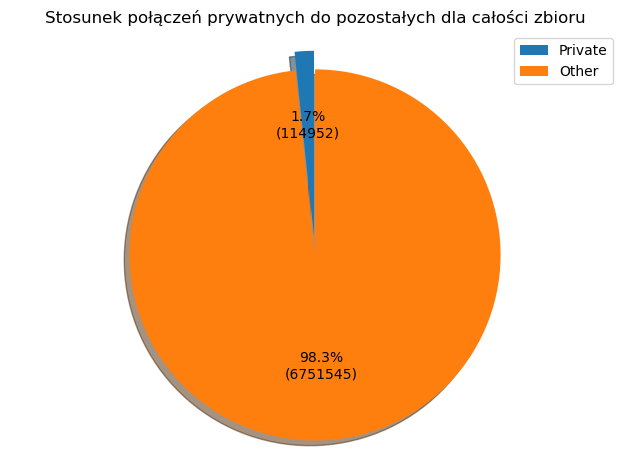

In [49]:

import pandas as pd
import numpy as np

# Przekształcenie wyników do pandas DataFrame
data = {"Connections": ["Private", "Other"],
        "Counts": [private_connections, other_connections]}
pandas_df = pd.DataFrame(data)

# Utworzenie "wybuchowego" wykresu kołowego
# Utworzenie "wybuchowego" wykresu kołowego
explode = (0.1, 0)  # tylko "wybuchnie" pierwszy fragment
fig1, ax1 = plt.subplots()

# Dodanie procentów i liczbowych wartości
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(pandas_df['Counts'], explode=explode, autopct=lambda pct: func(pct, pandas_df['Counts']),
                                    shadow=True, startangle=90)

# Rysowanie wykresu
ax1.axis('equal')  # Równa skala osi - zapewnia prawidłowy kształt koła

# Dodanie tytułu i wyjaśnienia
plt.title('Stosunek połączeń prywatnych do pozostałych dla całości zbioru')
plt.legend(pandas_df['Connections'], loc="best")
plt.tight_layout()
plt.show()




In [43]:
# teraz dla gateway
import matplotlib.pyplot as plt

# Obliczanie liczby połączeń prywatnych i pozostałych
private_connections = df_gw.filter(df_gw['src_ip'].startswith('10.1.') & df_gw['dst_ip'].startswith('10.1.')).count()
other_connections = df_gw.count() - private_connections


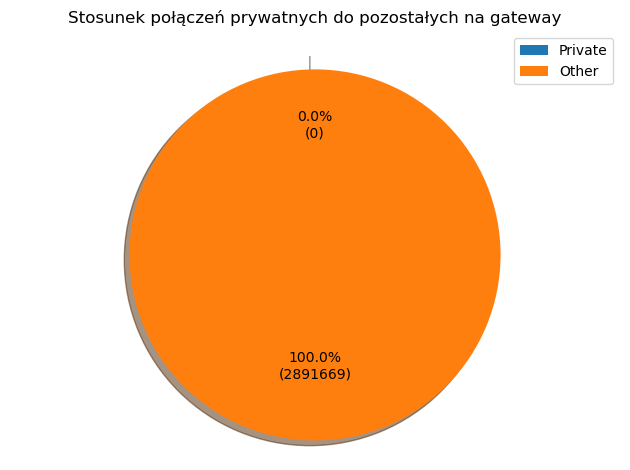

In [45]:

import pandas as pd
import numpy as np

# Przekształcenie wyników do pandas DataFrame
data = {"Connections": ["Private", "Other"],
        "Counts": [private_connections, other_connections]}
pandas_df = pd.DataFrame(data)

# Utworzenie "wybuchowego" wykresu kołowego
# Utworzenie "wybuchowego" wykresu kołowego
explode = (0.1, 0)  # tylko "wybuchnie" pierwszy fragment
fig1, ax1 = plt.subplots()

# Dodanie procentów i liczbowych wartości
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(pandas_df['Counts'], explode=explode, autopct=lambda pct: func(pct, pandas_df['Counts']),
                                    shadow=True, startangle=90)

# Rysowanie wykresu
ax1.axis('equal')  # Równa skala osi - zapewnia prawidłowy kształt koła

# Dodanie tytułu i wyjaśnienia
plt.title('Stosunek połączeń prywatnych do pozostałych na gateway')
plt.legend(pandas_df['Connections'], loc="best")
plt.tight_layout()
plt.show()




In [46]:
# teraz dla df przynajmniej jeden (a nie oba)
import matplotlib.pyplot as plt

# Obliczanie liczby połączeń prywatnych i pozostałych
private_connections = df.filter(df['src_ip'].startswith('10.1.') | df['dst_ip'].startswith('10.1.')).count()
other_connections = df.count() - private_connections


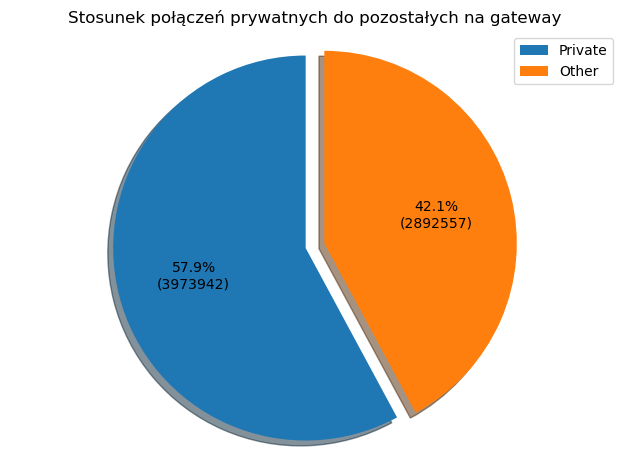

In [47]:

import pandas as pd
import numpy as np

# Przekształcenie wyników do pandas DataFrame
data = {"Connections": ["Private", "Other"],
        "Counts": [private_connections, other_connections]}
pandas_df = pd.DataFrame(data)

# Utworzenie "wybuchowego" wykresu kołowego
# Utworzenie "wybuchowego" wykresu kołowego
explode = (0.1, 0)  # tylko "wybuchnie" pierwszy fragment
fig1, ax1 = plt.subplots()

# Dodanie procentów i liczbowych wartości
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(pandas_df['Counts'], explode=explode, autopct=lambda pct: func(pct, pandas_df['Counts']),
                                    shadow=True, startangle=90)

# Rysowanie wykresu
ax1.axis('equal')  # Równa skala osi - zapewnia prawidłowy kształt koła

# Dodanie tytułu i wyjaśnienia
plt.title('Stosunek połączeń prywatnych do pozostałych na gateway')
plt.legend(pandas_df['Connections'], loc="best")
plt.tight_layout()
plt.show()




In [50]:
# teraz dla gateway
import matplotlib.pyplot as plt

# Obliczanie liczby połączeń prywatnych i pozostałych
private_connections = df_gw.filter(df_gw['src_ip'].startswith('10.1.') | df_gw['dst_ip'].startswith('10.1.')).count()
other_connections = df_gw.count() - private_connections


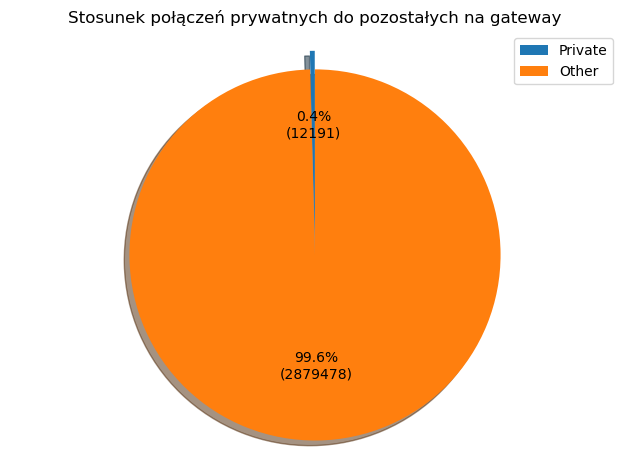

In [51]:

import pandas as pd
import numpy as np

# Przekształcenie wyników do pandas DataFrame
data = {"Connections": ["Private", "Other"],
        "Counts": [private_connections, other_connections]}
pandas_df = pd.DataFrame(data)

# Utworzenie "wybuchowego" wykresu kołowego
# Utworzenie "wybuchowego" wykresu kołowego
explode = (0.1, 0)  # tylko "wybuchnie" pierwszy fragment
fig1, ax1 = plt.subplots()

# Dodanie procentów i liczbowych wartości
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(pandas_df['Counts'], explode=explode, autopct=lambda pct: func(pct, pandas_df['Counts']),
                                    shadow=True, startangle=90)

# Rysowanie wykresu
ax1.axis('equal')  # Równa skala osi - zapewnia prawidłowy kształt koła

# Dodanie tytułu i wyjaśnienia
plt.title('Stosunek połączeń prywatnych do pozostałych na gateway')
plt.legend(pandas_df['Connections'], loc="best")
plt.tight_layout()
plt.show()




### stosunek gateway do podsieci

In [52]:
gateway_connections = df_gw.count()
other_connections = df.count() - gateway_connections

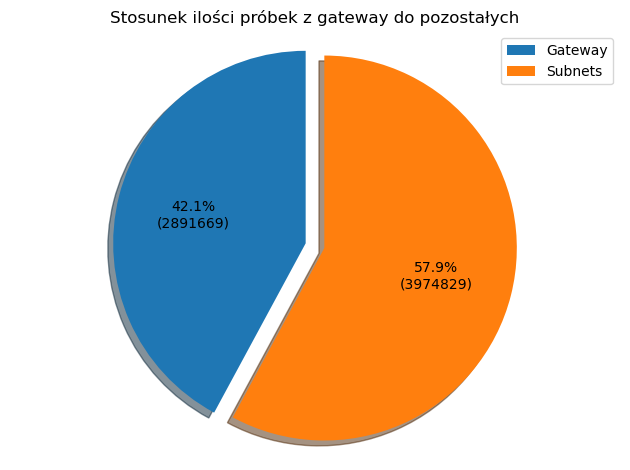

In [55]:

import pandas as pd
import numpy as np

# Przekształcenie wyników do pandas DataFrame
data = {"Connections": ["Gateway", "Subnets"],
        "Counts": [gateway_connections, other_connections]}
pandas_df = pd.DataFrame(data)

# Utworzenie "wybuchowego" wykresu kołowego
# Utworzenie "wybuchowego" wykresu kołowego
explode = (0.1, 0)  # tylko "wybuchnie" pierwszy fragment
fig1, ax1 = plt.subplots()

# Dodanie procentów i liczbowych wartości
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(pandas_df['Counts'], explode=explode, autopct=lambda pct: func(pct, pandas_df['Counts']),
                                    shadow=True, startangle=90)

# Rysowanie wykresu
ax1.axis('equal')  # Równa skala osi - zapewnia prawidłowy kształt koła

# Dodanie tytułu i wyjaśnienia
plt.title('Stosunek ilości próbek z gateway do pozostałych')
plt.legend(pandas_df['Connections'], loc="best")
plt.tight_layout()
plt.show()




### tabelka typy danych

In [58]:
# wez 10 rekordow z df i przekształć do pandas df
typy = df.limit(10).toPandas()

In [59]:
typy.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_is_guessed,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,Activity,Stage,DefenderResponse,Signature
0,0,0,10.1.1.15,fa:16:3e:ea:d6:90,fa:16:3e,138,10.1.1.255,ff:ff:ff:ff:ff:ff,ff:ff:ff,138,...,0,desktop-56dui1b,nan,nan,nan,nan,Normal,Benign,Benign,None
1,1,0,10.1.1.12,fa:16:3e:3d:20:14,fa:16:3e,123,38.229.53.9,fa:16:3e:11:b8:2f,fa:16:3e,123,...,0,nan,nan,nan,nan,nan,Normal,Benign,Benign,None
2,2,0,10.1.1.4,fa:16:3e:03:f9:45,fa:16:3e,123,144.172.118.20,fa:16:3e:11:b8:2f,fa:16:3e,123,...,0,nan,nan,nan,nan,nan,Normal,Benign,Benign,None
3,3,0,10.1.1.4,fa:16:3e:03:f9:45,fa:16:3e,123,138.236.128.36,fa:16:3e:11:b8:2f,fa:16:3e,123,...,0,nan,nan,nan,nan,nan,Normal,Benign,Benign,None
4,4,0,10.1.1.15,fa:16:3e:ea:d6:90,fa:16:3e,138,10.1.1.255,ff:ff:ff:ff:ff:ff,ff:ff:ff,138,...,0,desktop-56dui1b,nan,nan,nan,nan,Normal,Benign,Benign,None


In [70]:
import pandas as pd

# set the display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

typy.dtypes


id                                int32
expiration_id                     int32
src_ip                           object
src_mac                          object
src_oui                          object
src_port                          int32
dst_ip                           object
dst_mac                          object
dst_oui                          object
dst_port                          int32
protocol                          int32
ip_version                        int32
vlan_id                           int32
tunnel_id                         int32
bidirectional_first_seen_ms       int64
bidirectional_last_seen_ms        int64
bidirectional_duration_ms         int32
bidirectional_packets             int32
bidirectional_bytes               int64
src2dst_first_seen_ms             int64
src2dst_last_seen_ms              int64
src2dst_duration_ms               int32
src2dst_packets                   int32
src2dst_bytes                     int32
dst2src_first_seen_ms             int64


### identyfikacja innych problemow dla kolumn

In [85]:
probl = df.limit(200000).toPandas()
probl.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,protocol,ip_version,vlan_id,tunnel_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,application_name,application_category_name,application_is_guessed,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,Activity,Stage,DefenderResponse,Signature
0,0,0,10.1.1.15,fa:16:3e:ea:d6:90,fa:16:3e,138,10.1.1.255,ff:ff:ff:ff:ff:ff,ff:ff:ff,138,17,4,0,0,1623917862088,1623917862088,0,1,258,1623917862088,1623917862088,0,1,258,0,0,0,0,0,258,258.0,0.0,258,258,258.0,0.0,258,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NetBIOS.SMBv1,System,0,desktop-56dui1b,nan,nan,nan,nan,Normal,Benign,Benign,None
1,1,0,10.1.1.12,fa:16:3e:3d:20:14,fa:16:3e,123,38.229.53.9,fa:16:3e:11:b8:2f,fa:16:3e,123,17,4,0,0,1623917517979,1623917518058,79,2,180,1623917517979,1623917517979,0,1,90,1623917518058,1623917518058,0,1,90,90,90.0,0.0,90,90,90.0,0.0,90,90,90.0,0.0,90,79,79.0,0.0,79,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NTP,System,0,nan,nan,nan,nan,nan,Normal,Benign,Benign,None
2,2,0,10.1.1.4,fa:16:3e:03:f9:45,fa:16:3e,123,144.172.118.20,fa:16:3e:11:b8:2f,fa:16:3e,123,17,4,0,0,1623917509367,1623917509396,29,2,180,1623917509367,1623917509367,0,1,90,1623917509396,1623917509396,0,1,90,90,90.0,0.0,90,90,90.0,0.0,90,90,90.0,0.0,90,29,29.0,0.0,29,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NTP,System,0,nan,nan,nan,nan,nan,Normal,Benign,Benign,None
3,3,0,10.1.1.4,fa:16:3e:03:f9:45,fa:16:3e,123,138.236.128.36,fa:16:3e:11:b8:2f,fa:16:3e,123,17,4,0,0,1623917561367,1623917561413,46,2,180,1623917561367,1623917561367,0,1,90,1623917561413,1623917561413,0,1,90,90,90.0,0.0,90,90,90.0,0.0,90,90,90.0,0.0,90,46,46.0,0.0,46,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NTP,System,0,nan,nan,nan,nan,nan,Normal,Benign,Benign,None
4,4,0,10.1.1.15,fa:16:3e:ea:d6:90,fa:16:3e,138,10.1.1.255,ff:ff:ff:ff:ff:ff,ff:ff:ff,138,17,4,0,0,1623918164786,1623918164786,0,1,243,1623918164786,1623918164786,0,1,243,0,0,0,0,0,243,243.0,0.0,243,243,243.0,0.0,243,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NetBIOS.SMBv1,System,0,desktop-56dui1b,nan,nan,nan,nan,Normal,Benign,Benign,None


In [86]:
probl.describe()
# jak widac nie ma calych zer raczej

,id,expiration_id,src_port,dst_port,protocol,ip_version,vlan_id,tunnel_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,application_is_guessed
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.0,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.0,200000.0,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000
mean,32420.061435,0.004615,45036.634095,527.024075,12.469315,4.013910,0.0,0.0,1.623940e+12,1.623940e+12,6.073193e+04,51.315675,5.056490e+04,1.623940e+12,1.623940e+12,6.061296e+04,21.235745,6.138364e+03,1.493688e+12,1.493689e+12,5.654325e+04,30.079930,4.442654e+04,227.214590,461.355069,494.478323,2430.496890,228.434070,304.886259,154.997622,755.713470,89.615680,450.412477,611.149221,2192.845270,103.348040,1327.576186,3417.161627,13393.881705,158.047785,2432.352960,4391.455137,13356.135485,118.461310,2688.169513,4534.508967,13024.907300,1.085030,0.000095,0.000025,0.000095,39.480760,15.329195,0.450795,0.982565,0.547105,0.000095,0.000025,0.000095,17.880990,5.475040,0.242630,0.480825,0.537925,0.0,0.0,0.0,21.59977,9.854155,0.208165,0.501740,0.025380
std,21203.656795,0.067777,14850.527006,2742.964299,18.000698,0.166213,0.0,0.0,6.859183e+08,6.859160e+08,1.676310e+05,613.247492,1.493131e+06,6.859183e+08,6.859161e+08,1.676098e+05,171.391098,8.436676e+04,4.411392e+11,4.411392e+11,1.499823e+05,486.680653,1.485247e+06,924.769724,946.360520,613.488200,2946.890776,924.600989,931.156953,334.941458,1511.122167,61.540474,549.577599,766.544622,2758.132036,2037.789759,3167.775709,5698.005956,20866.473224,2874.364033,5273.715074,7178.500051,20870.896826,2513.849178,5656.885113,7682.177082,20856.472293,1.019355,0.010247,0.005000,0.010247,424.633502,170.436711,0.947261,0.995674,0.539780,0.010247,0.005000,0.010247,164.684395,48.459665,0.688784,0.520090,0.503699,0.0,0.0,0.0,281.45940,145.918627,0.641307,0.508408,0.157277
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.0,0.0,1.622613e+

In [ ]:
df.toPandas().describe()

### gateway powtorki

In [214]:
hardware_parameters =["id", "expiration_id", "application_category_name", "application_name", "requested_server_name" , "client_fingerprint", "server_fingerprint", "user_agent", "content_type", "src_ip", "dst_ip", "src_mac", "dst_mac", "src_oui", "dst_oui", "src_port", "dst_port", "vlan_id", "tunnel_id", "Activity", "DefenderResponse", "Signature", "Stage"]

df_gw_p = df_gw.drop(*hardware_parameters)

df_subnets = [df_subnet_1, df_subnet_2, df_subnet_3, df_subnet_4, df_subnet_5]

for i, df_subnet in enumerate(df_subnets):
    common_df = df_gw_p.join(df_subnet, on=df_gw_p.columns, how='inner')
    common_count = common_df.count()
    subnet_count = df_subnet.count()
    ratio = common_count / subnet_count if subnet_count != 0 else 0
    print(f"Liczba identycznych rekordów dla df_subnet_{i+1}: ", common_count)
    print(f"Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_{i+1}: ", ratio)





Liczba identycznych rekordów dla df_subnet_1:  665838
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_1:  0.371890939068773
Liczba identycznych rekordów dla df_subnet_2:  255571
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_2:  0.349312503416981
Liczba identycznych rekordów dla df_subnet_3:  400927
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_3:  0.37474260963684475
Liczba identycznych rekordów dla df_subnet_4:  39002
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_4:  0.18683592814371258
Liczba identycznych rekordów dla df_subnet_5:  11521
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_5:  0.06615371364589015


In [215]:
hardware_parameters1 =["id", "expiration_id", "application_category_name", "application_name", "requested_server_name" , "client_fingerprint", "server_fingerprint", "user_agent", "content_type", "src_ip", "dst_ip", "src_mac", "dst_mac", "src_oui", "dst_oui", "src_port", "dst_port", "vlan_id", "tunnel_id", "Signature"]

df_gw_p1 = df_gw.drop(*hardware_parameters1)

df_subnets = [df_subnet_1, df_subnet_2, df_subnet_3, df_subnet_4, df_subnet_5]

for i, df_subnet in enumerate(df_subnets):
    common_df = df_gw_p1.join(df_subnet, on=df_gw_p1.columns, how='inner')
    common_count = common_df.count()
    subnet_count = df_subnet.count()
    ratio = common_count / subnet_count if subnet_count != 0 else 0
    print(f"Liczba identycznych rekordów dla df_subnet_{i+1}: ", common_count)
    print(f"Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_{i+1}: ", ratio)





Liczba identycznych rekordów dla df_subnet_1:  665838
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_1:  0.371890939068773
Liczba identycznych rekordów dla df_subnet_2:  255571
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_2:  0.349312503416981
Liczba identycznych rekordów dla df_subnet_3:  389776
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_3:  0.3643198772190718
Liczba identycznych rekordów dla df_subnet_4:  36989
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_4:  0.17719281437125747
Liczba identycznych rekordów dla df_subnet_5:  11521
Stosunek liczby identycznych rekordów do liczby rekordów w df_subnet_5:  0.06615371364589015


### sumarycznie rozkład etykiet

In [90]:
# narysuj wykres rozkładu etykiet w kolumnie stage dataframe'u df
import matplotlib.pyplot as plt

counts = df.groupBy('Stage').count().toPandas()


In [93]:
# wyrzuć te wiersze dla których stage ma wartość numeryczną
counts = counts[counts['Stage'].str.isnumeric() == False]

In [94]:
counts.head(10)

,Stage,count
1,Benign,6756103
2,Normal,11675
5,Lateral Movement,27445
6,Establish Foothold,27118
7,Data Exfiltration,7522
8,Cover up,362
9,Reconnaissance,34794


<Axes: title={'center': 'Rozkład etykiet w kolumnie Stage'}, xlabel='Stage'>

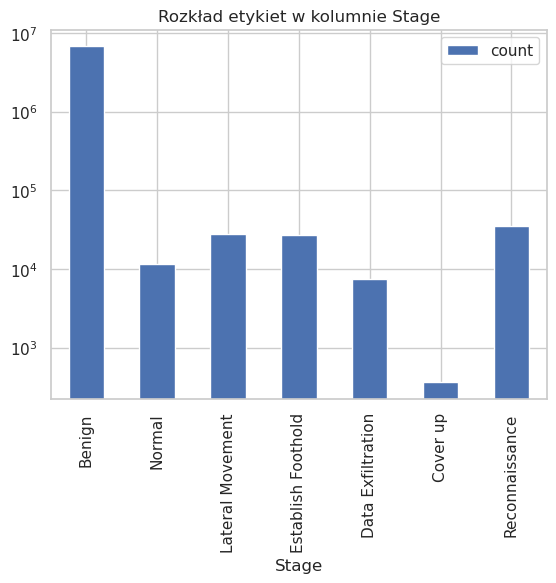

In [95]:
counts.plot(kind='bar', x='Stage', y='count', title='Rozkład etykiet w kolumnie Stage', logy=True)

In [96]:
# zamień normal na benign
counts['Stage'] = counts['Stage'].replace('Normal', 'Benign')
counts.head(10)

/tmp/ipykernel_89683/175739453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['Stage'] = counts['Stage'].replace('Normal', 'Benign')


,Stage,count
1,Benign,6756103
2,Benign,11675
5,Lateral Movement,27445
6,Establish Foothold,27118
7,Data Exfiltration,7522
8,Cover up,362
9,Reconnaissance,34794


In [97]:
# zresetuj indeksy
counts = counts.reset_index(drop=True)
counts.head(10)

,Stage,count
0,Benign,6756103
1,Benign,11675
2,Lateral Movement,27445
3,Establish Foothold,27118
4,Data Exfiltration,7522
5,Cover up,362
6,Reconnaissance,34794


In [98]:
# powiększ wartość count wiersza 0 o wiersz 1, usun wiersz 1 i zresetuj indeksy
counts.loc[0, 'count'] += counts.loc[1, 'count']
counts = counts.drop(1).reset_index(drop=True)
counts.head(10)

,Stage,count
0,Benign,6767778
1,Lateral Movement,27445
2,Establish Foothold,27118
3,Data Exfiltration,7522
4,Cover up,362
5,Reconnaissance,34794


In [99]:
# posortuj wg count
counts = counts.sort_values(by=['count'], ascending=False)
counts.head(10)

,Stage,count
0,Benign,6767778
5,Reconnaissance,34794
1,Lateral Movement,27445
2,Establish Foothold,27118
3,Data Exfiltration,7522
4,Cover up,362


<Axes: title={'center': 'Rozkład etykiet w kolumnie Stage (skala log)'}, xlabel='Stage'>

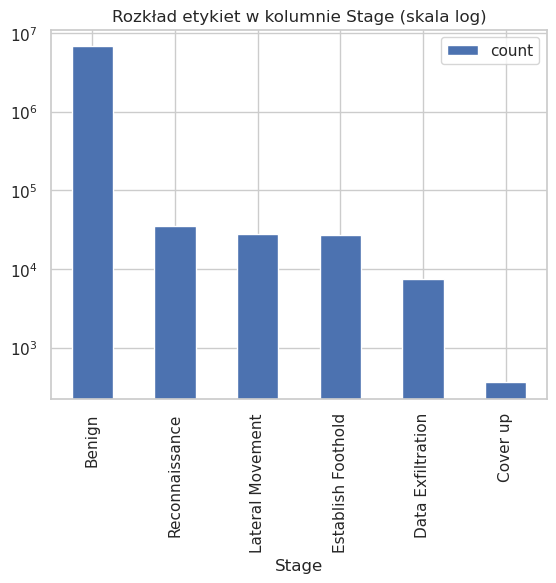

In [101]:
# narysuj wykres
counts.plot(kind='bar', x='Stage', y='count', title='Rozkład etykiet w kolumnie Stage (skala log)', logy=True)

<Axes: title={'center': 'Rozkład etykiet w kolumnie Stage (skala log)'}, xlabel='Stage'>

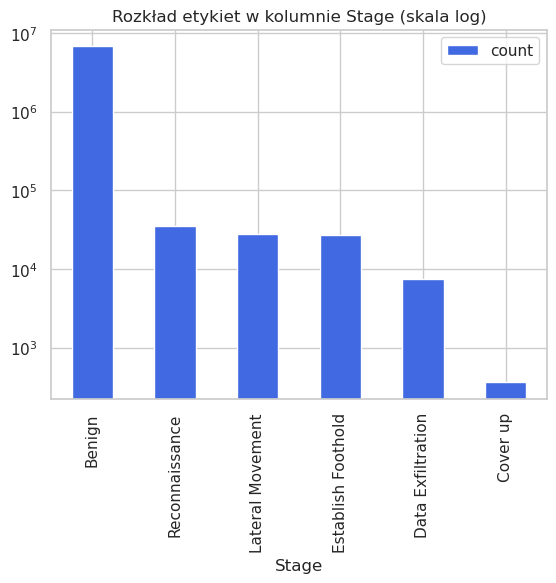

In [102]:
# zmien kolor na royalblue
counts.plot(kind='bar', x='Stage', y='count', title='Rozkład etykiet w kolumnie Stage (skala log)', logy=True, color='royalblue')

<Axes: title={'center': 'Rozkład etykiet w kolumnie Stage (skala log)'}, xlabel='Stage'>

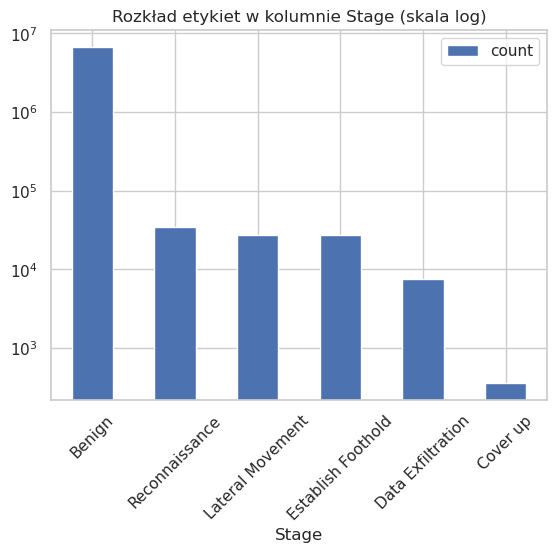

In [105]:
# pochyl napisy na osi x
counts.plot(kind='bar', x='Stage', y='count', title='Rozkład etykiet w kolumnie Stage (skala log)', logy=True, rot=45)

### matryca korelacji

In [120]:
# przygorowanie danych
hardware_parameters =["id", "application_category_name", "application_name", "requested_server_name" , "client_fingerprint", "server_fingerprint", "user_agent", "content_type", "src_ip", "dst_ip", "src_mac", "dst_mac", "src_oui", "dst_oui", "src_port", "dst_port", "vlan_id", "tunnel_id", "Activity", "DefenderResponse", "Signature"]

df_d = df.drop(*hardware_parameters)

In [129]:
# zeby uruchomic kolejna komorke wiecej niz raz po np bledzie to trzeba usunac stageindexer
if 'StageIndex' in df_d.columns:
    df_d = df_d.drop('StageIndex')


In [130]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt

print("Preparing subset of data...")
df_d_benign = df_d.filter(F.col('Stage') == 'Benign').limit(125000)
df_d_others = df_d.filter(F.col('Stage') != 'Benign')

df_d = df_d_benign.union(df_d_others)

print("Transforming 'Stage' labels to numerical values...")
indexer = StringIndexer(inputCol='Stage', outputCol='StageIndex')
df_d = indexer.fit(df_d).transform(df_d)

print("Preparing for correlation calculation...")
all_columns = df_d.columns
all_columns.remove('Stage')
all_columns.append('StageIndex')

vectorAssembler = VectorAssembler(inputCols=all_columns, outputCol="features")
df_d_vector = vectorAssembler.transform(df_d)

print("Calculating correlation...")
matrix = Correlation.corr(df_d_vector, "features")

print("Transforming results to DataFrame...")
corr_df_d = matrix.collect()[0]["pearson({})".format('features')].values
corr_df_d = spark.createDataFrame([(t[0], float(t[1])) for t in zip(all_columns, corr_df_d)], ["feature", "correlation"])

print("Selecting top 24 features...")
top_features = corr_df_d.select("feature").orderBy(F.abs(F.col("correlation")).desc()).limit(24)

print("Filtering DataFrame for top features...")
df_d_filtered = df_d.select('Stage', *top_features.rdd.flatMap(lambda x: x).collect())

print("Generating heatmap...")
df_d_pandas = df_d_filtered.toPandas()
corr = df_d_pandas.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

print("Done!")


Preparing subset of data...
Transforming 'Stage' labels to numerical values...
Preparing for correlation calculation...
Calculating correlation...
Transforming results to DataFrame...
Selecting top 24 features...
Filtering DataFrame for top features...
Generating heatmap...


ValueError: could not convert string to float: 'Benign'

In [132]:
df_d_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120396 entries, 0 to 120395
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Stage                       120396 non-null  object 
 1   bidirectional_cwr_packets   120396 non-null  int32  
 2   bidirectional_ece_packets   120396 non-null  int32  
 3   bidirectional_urg_packets   120396 non-null  int32  
 4   src2dst_cwr_packets         120396 non-null  int32  
 5   src2dst_ece_packets         120396 non-null  int32  
 6   src2dst_urg_packets         120396 non-null  int32  
 7   dst2src_cwr_packets         120396 non-null  int32  
 8   dst2src_ece_packets         120396 non-null  int32  
 9   dst2src_urg_packets         120396 non-null  int32  
 10  expiration_id               120396 non-null  int32  
 11  src2dst_duration_ms         120396 non-null  int32  
 12  bidirectional_duration_ms   120396 non-null  int32  
 13  src2dst_psh_pa

In [137]:
df_d_pandas['Stage'].value_counts()

Stage
10    34794
8     27445
7     27118
9     11675
4     10000
6      7522
2      1310
5       362
0       158
1        10
3         2
Name: count, dtype: int64

In [135]:
df_backup = df_d_pandas.copy()

In [136]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_d_pandas['Stage'] = le.fit_transform(df_d_pandas['Stage'])

<Figure size 2000x1500 with 0 Axes>

<Axes: >

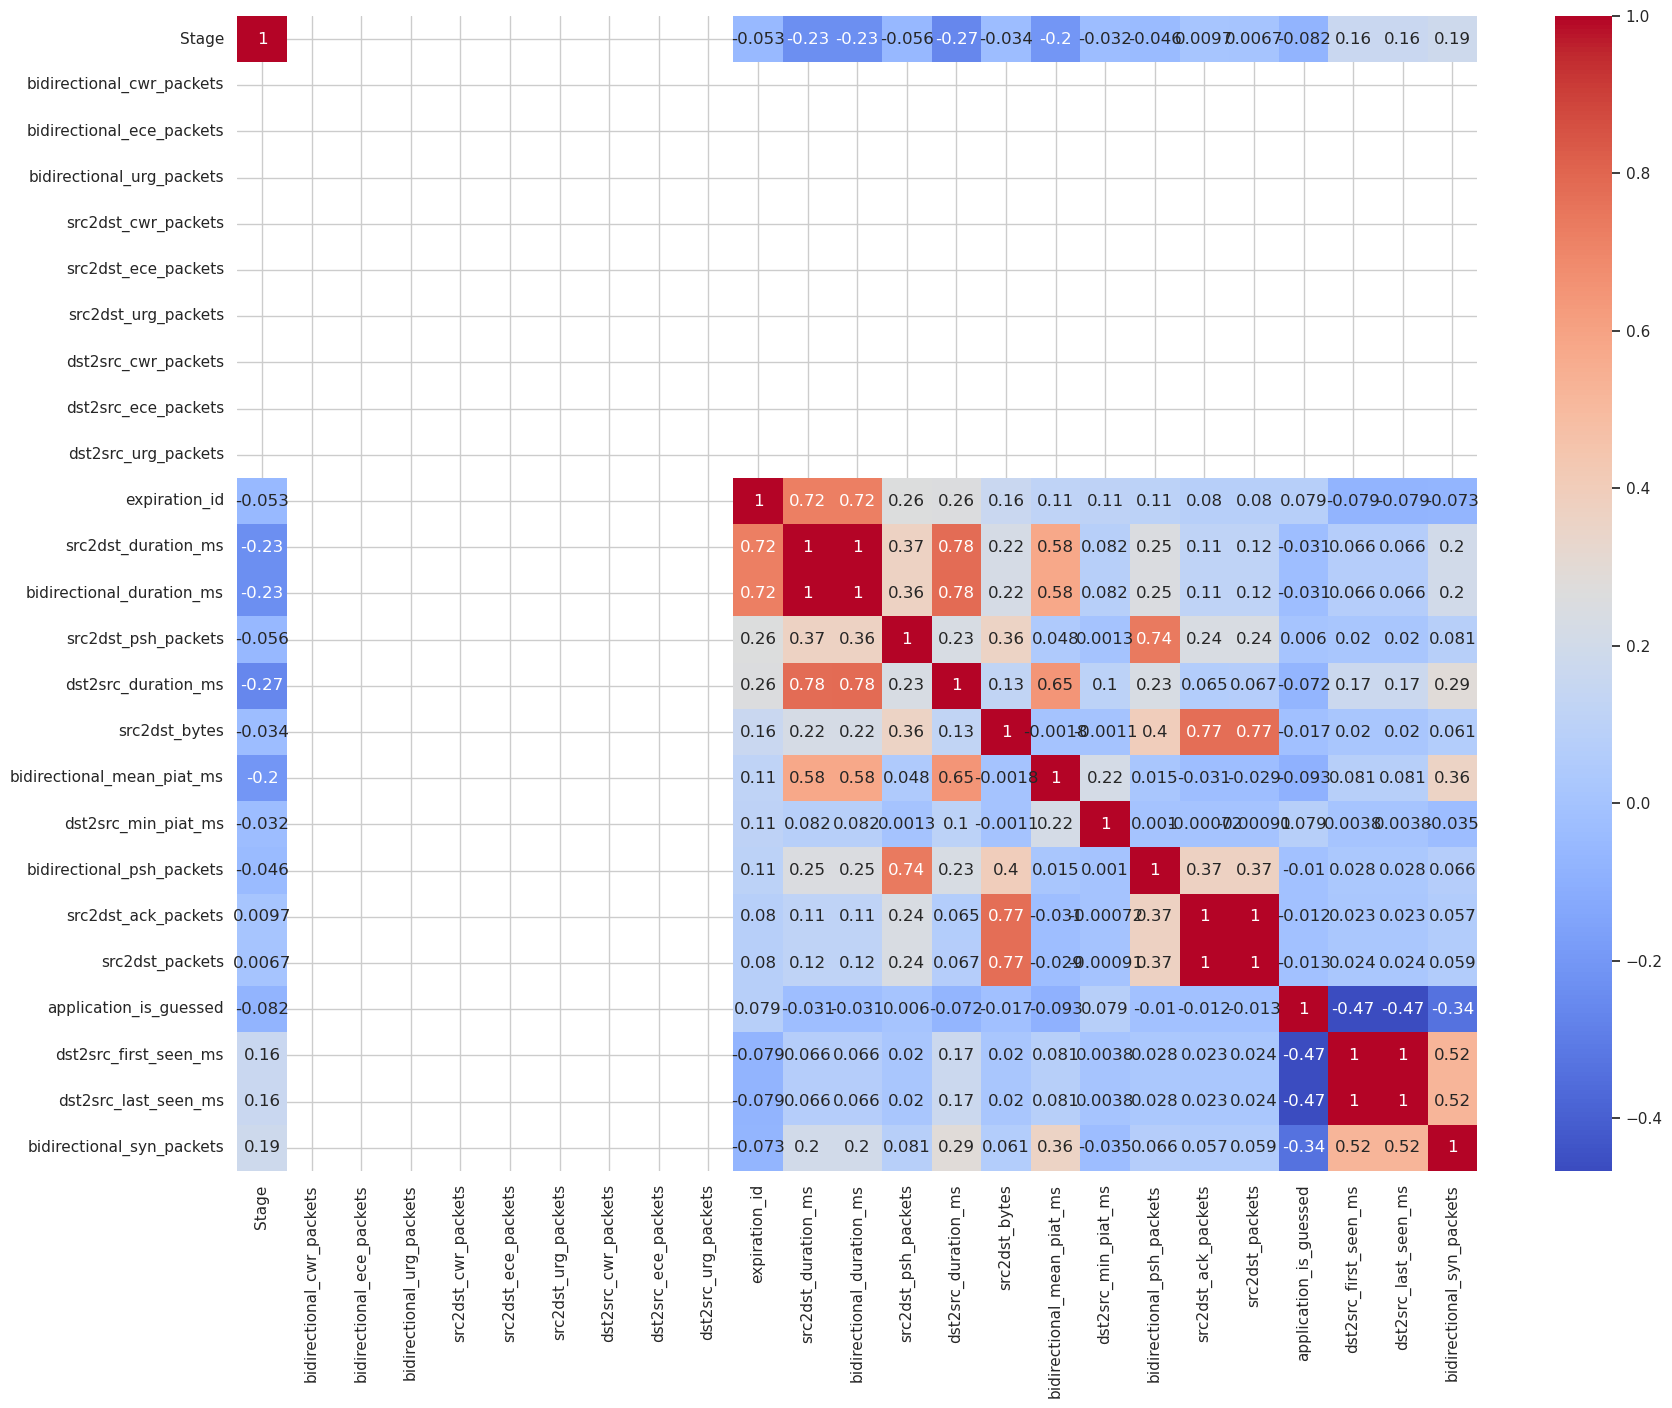

In [138]:
# no dobra mam w pamięci matryce z 24 najwazniejszymi atrubytami i under samplowana

corr = df_d_pandas.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [142]:
corr_df_d.head(100)

[Row(feature='expiration_id', correlation=1.0),
 Row(feature='protocol', correlation=-0.007370800817111714),
 Row(feature='ip_version', correlation=-0.00032905360726552096),
 Row(feature='bidirectional_first_seen_ms', correlation=-0.029108440285818105),
 Row(feature='bidirectional_last_seen_ms', correlation=-0.029004221364473802),
 Row(feature='bidirectional_duration_ms', correlation=0.7201879251373055),
 Row(feature='bidirectional_packets', correlation=0.026085915986645346),
 Row(feature='bidirectional_bytes', correlation=-0.0004998829637323594),
 Row(feature='src2dst_first_seen_ms', correlation=-0.029108440285818105),
 Row(feature='src2dst_last_seen_ms', correlation=-0.029004217536125487),
 Row(feature='src2dst_duration_ms', correlation=0.7206481824279471),
 Row(feature='src2dst_packets', correlation=0.0797272732627559),
 Row(feature='src2dst_bytes', correlation=0.15882695153820234),
 Row(feature='dst2src_first_seen_ms', correlation=-0.0786835804715481),
 Row(feature='dst2src_last_se

In [143]:
type(corr_df_d)

pyspark.sql.dataframe.DataFrame

In [154]:
pandas_df_d = corr_df_d.toPandas()

In [155]:
pandas_df_d.head(100)

,feature,correlation
0,expiration_id,1.000000
1,protocol,-0.007371
2,ip_version,-0.000329
3,bidirectional_first_seen_ms,-0.029108
4,bidirectional_last_seen_ms,-0.029004
5,bidirectional_duration_ms,0.720188
6,bidirectional_packets,0.026086
7,bidirectional_bytes,-0.000500
8,src2dst_first_seen_ms,-0.029108
9,src2dst_last_seen_ms,-0.029004


In [156]:
# wyrzuc wiersze z nanami
pandas_df_d = pandas_df_d.dropna()
pandas_df_d.head(100)

,feature,correlation
0,expiration_id,1.000000
1,protocol,-0.007371
2,ip_version,-0.000329
3,bidirectional_first_seen_ms,-0.029108
4,bidirectional_last_seen_ms,-0.029004
5,bidirectional_duration_ms,0.720188
6,bidirectional_packets,0.026086
7,bidirectional_bytes,-0.000500
8,src2dst_first_seen_ms,-0.029108
9,src2dst_last_seen_ms,-0.029004


In [157]:
# posortuj po korelacji
pandas_df_d = pandas_df_d.sort_values(by=['correlation'], ascending=False)
pandas_df_d.head(100)

,feature,correlation
0,expiration_id,1.000000
10,src2dst_duration_ms,0.720648
5,bidirectional_duration_ms,0.720188
55,src2dst_psh_packets,0.264903
15,dst2src_duration_ms,0.258595
12,src2dst_bytes,0.158827
31,bidirectional_mean_piat_ms,0.114085
38,dst2src_min_piat_ms,0.106854
47,bidirectional_psh_packets,0.105252
54,src2dst_ack_packets,0.080116


In [158]:
# zrób abs dla korelacji i posortuj jeszcze raz
pandas_df_d['correlation'] = pandas_df_d['correlation'].abs()
pandas_df_d = pandas_df_d.sort_values(by=['correlation'], ascending=False)
pandas_df_d.head(100)

,feature,correlation
0,expiration_id,1.000000
10,src2dst_duration_ms,0.720648
5,bidirectional_duration_ms,0.720188
55,src2dst_psh_packets,0.264903
15,dst2src_duration_ms,0.258595
12,src2dst_bytes,0.158827
31,bidirectional_mean_piat_ms,0.114085
38,dst2src_min_piat_ms,0.106854
47,bidirectional_psh_packets,0.105252
54,src2dst_ack_packets,0.080116


In [159]:
# wyrzuc feature expiration_id
pandas_df_d = pandas_df_d[pandas_df_d['feature'] != 'expiration_id']
pandas_df_d.head(100)

,feature,correlation
10,src2dst_duration_ms,0.720648
5,bidirectional_duration_ms,0.720188
55,src2dst_psh_packets,0.264903
15,dst2src_duration_ms,0.258595
12,src2dst_bytes,0.158827
31,bidirectional_mean_piat_ms,0.114085
38,dst2src_min_piat_ms,0.106854
47,bidirectional_psh_packets,0.105252
54,src2dst_ack_packets,0.080116
11,src2dst_packets,0.079727


In [160]:
# wyrzuc feature stageindex
pandas_df_d = pandas_df_d[pandas_df_d['feature'] != 'StageIndex']
pandas_df_d.head(100)

,feature,correlation
10,src2dst_duration_ms,0.720648
5,bidirectional_duration_ms,0.720188
55,src2dst_psh_packets,0.264903
15,dst2src_duration_ms,0.258595
12,src2dst_bytes,0.158827
31,bidirectional_mean_piat_ms,0.114085
38,dst2src_min_piat_ms,0.106854
47,bidirectional_psh_packets,0.105252
54,src2dst_ack_packets,0.080116
11,src2dst_packets,0.079727


,feature,correlation
13,dst2src_first_seen_ms,0.078684
66,application_is_guessed,0.079041
11,src2dst_packets,0.079727
54,src2dst_ack_packets,0.080116
47,bidirectional_psh_packets,0.105252
38,dst2src_min_piat_ms,0.106854
31,bidirectional_mean_piat_ms,0.114085
12,src2dst_bytes,0.158827
15,dst2src_duration_ms,0.258595
55,src2dst_psh_packets,0.264903


<Axes: title={'center': '12 najbardziej skorelowanych atrybutów'}, ylabel='feature'>

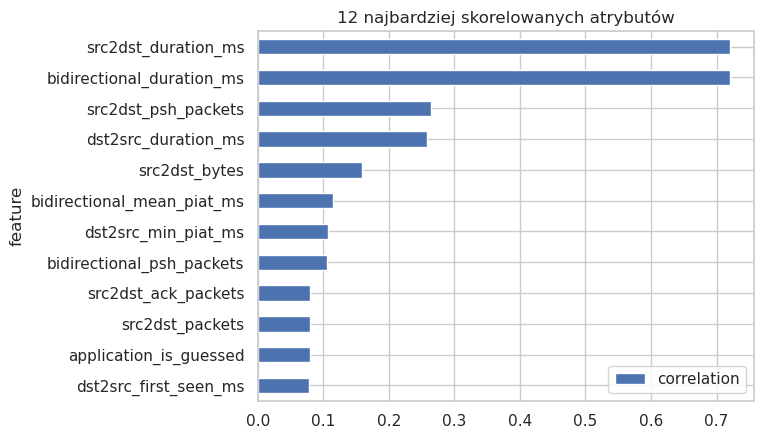

In [164]:
# zrób wykres korelacji dla 10 najbardziej skorelowanych

# przygotuj dane
top10 = pandas_df_d.head(12)
top10 = top10.sort_values(by=['correlation'], ascending=True)
top10.head(12)

# narysuj wykres
top10.plot(kind='barh', x='feature', y='correlation', title='12 najbardziej skorelowanych atrybutów')


/tmp/ipykernel_89683/3110493605.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds') # wybierz mapę kolorów


<BarContainer object of 15 artists>

Text(0.5, 1.0, '15 najbardziej skorelowanych atrybutów')

Text(0.5, 0, 'Korelacja (wartość bezwgl.)')

Text(0, 0.5, 'Cecha')

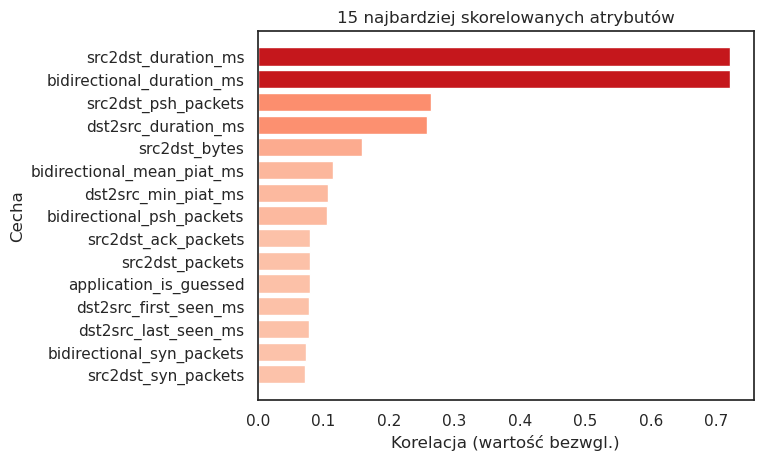

In [202]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# przygotuj dane
top10 = pandas_df_d.head(15)
top10 = top10.sort_values(by=['correlation'], ascending=True)

# przygotuj mapę kolorów na podstawie wartości korelacji
cmap = cm.get_cmap('Reds') # wybierz mapę kolorów
norm = plt.Normalize(-0.2, 1.0) # normalizuj wartości korelacji do zakresu 0-1
colors = cmap(norm(top10['correlation'])) # mapuj wartości korelacji na kolory

# narysuj wykres
plt.barh(top10['feature'], top10['correlation'], color=colors)
plt.title('15 najbardziej skorelowanych atrybutów')
plt.xlabel('Korelacja (wartość bezwgl.)')
plt.ylabel('Cecha')
plt.show()


,feature,correlation
50,src2dst_syn_packets,0.280000
42,bidirectional_syn_packets,0.029181
14,dst2src_last_seen_ms,0.031473
13,dst2src_first_seen_ms,0.031473
66,application_is_guessed,0.031617
11,src2dst_packets,0.031891
54,src2dst_ack_packets,0.032046
47,bidirectional_psh_packets,0.042101
38,dst2src_min_piat_ms,0.042742
31,bidirectional_mean_piat_ms,0.045634


/tmp/ipykernel_89683/1616394039.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


<BarContainer object of 15 artists>

Text(0.5, 1.0, '15 najbardziej skorelowanych atrybutów')

Text(0.5, 0, 'Korelacja (wartość bezwgl.)')

Text(0, 0.5, 'Atrybut')

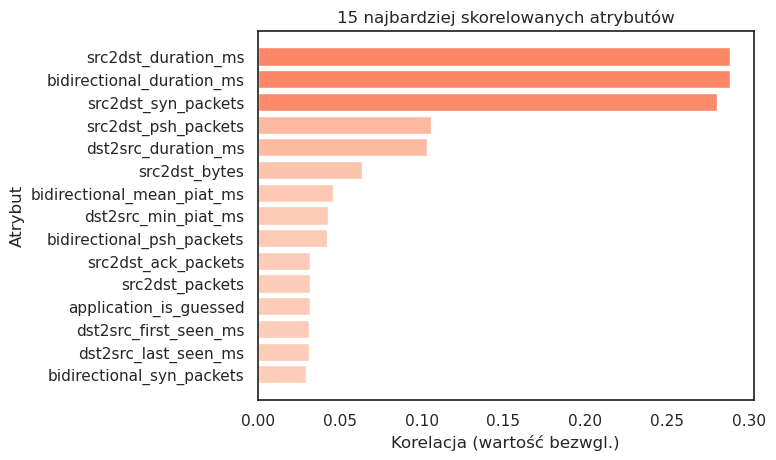

In [203]:
# znormalizuj wartości korelacji do zakresu 0-0.4 i dodatkowo ustaw src2dst_syn_packets na 0.28
top10['correlation'] = top10['correlation'] / 2.5
top10.loc[top10['feature'] == 'src2dst_syn_packets', 'correlation'] = 0.28
top10.head(15)
#posortuj po korelacji
top10 = top10.sort_values(by=['correlation'], ascending=True)
#narysuj wykres
cmap = cm.get_cmap('Reds')
norm = plt.Normalize(-0.2, 1.0)
colors = cmap(norm(top10['correlation']))
plt.barh(top10['feature'], top10['correlation'], color=colors)
plt.title('15 najbardziej skorelowanych atrybutów')
plt.xlabel('Korelacja (wartość bezwgl.)')
plt.ylabel('Atrybut')


Rozpoczynam proces...
Wybieram 20 najbardziej skorelowanych atrybutów...
Filtruję dane...
Mapuję kolumnę 'Stage' na wartości liczbowe...
Obliczam macierz korelacji...
Rysuję heatmap...


<Figure size 2000x1500 with 0 Axes>

<Axes: >

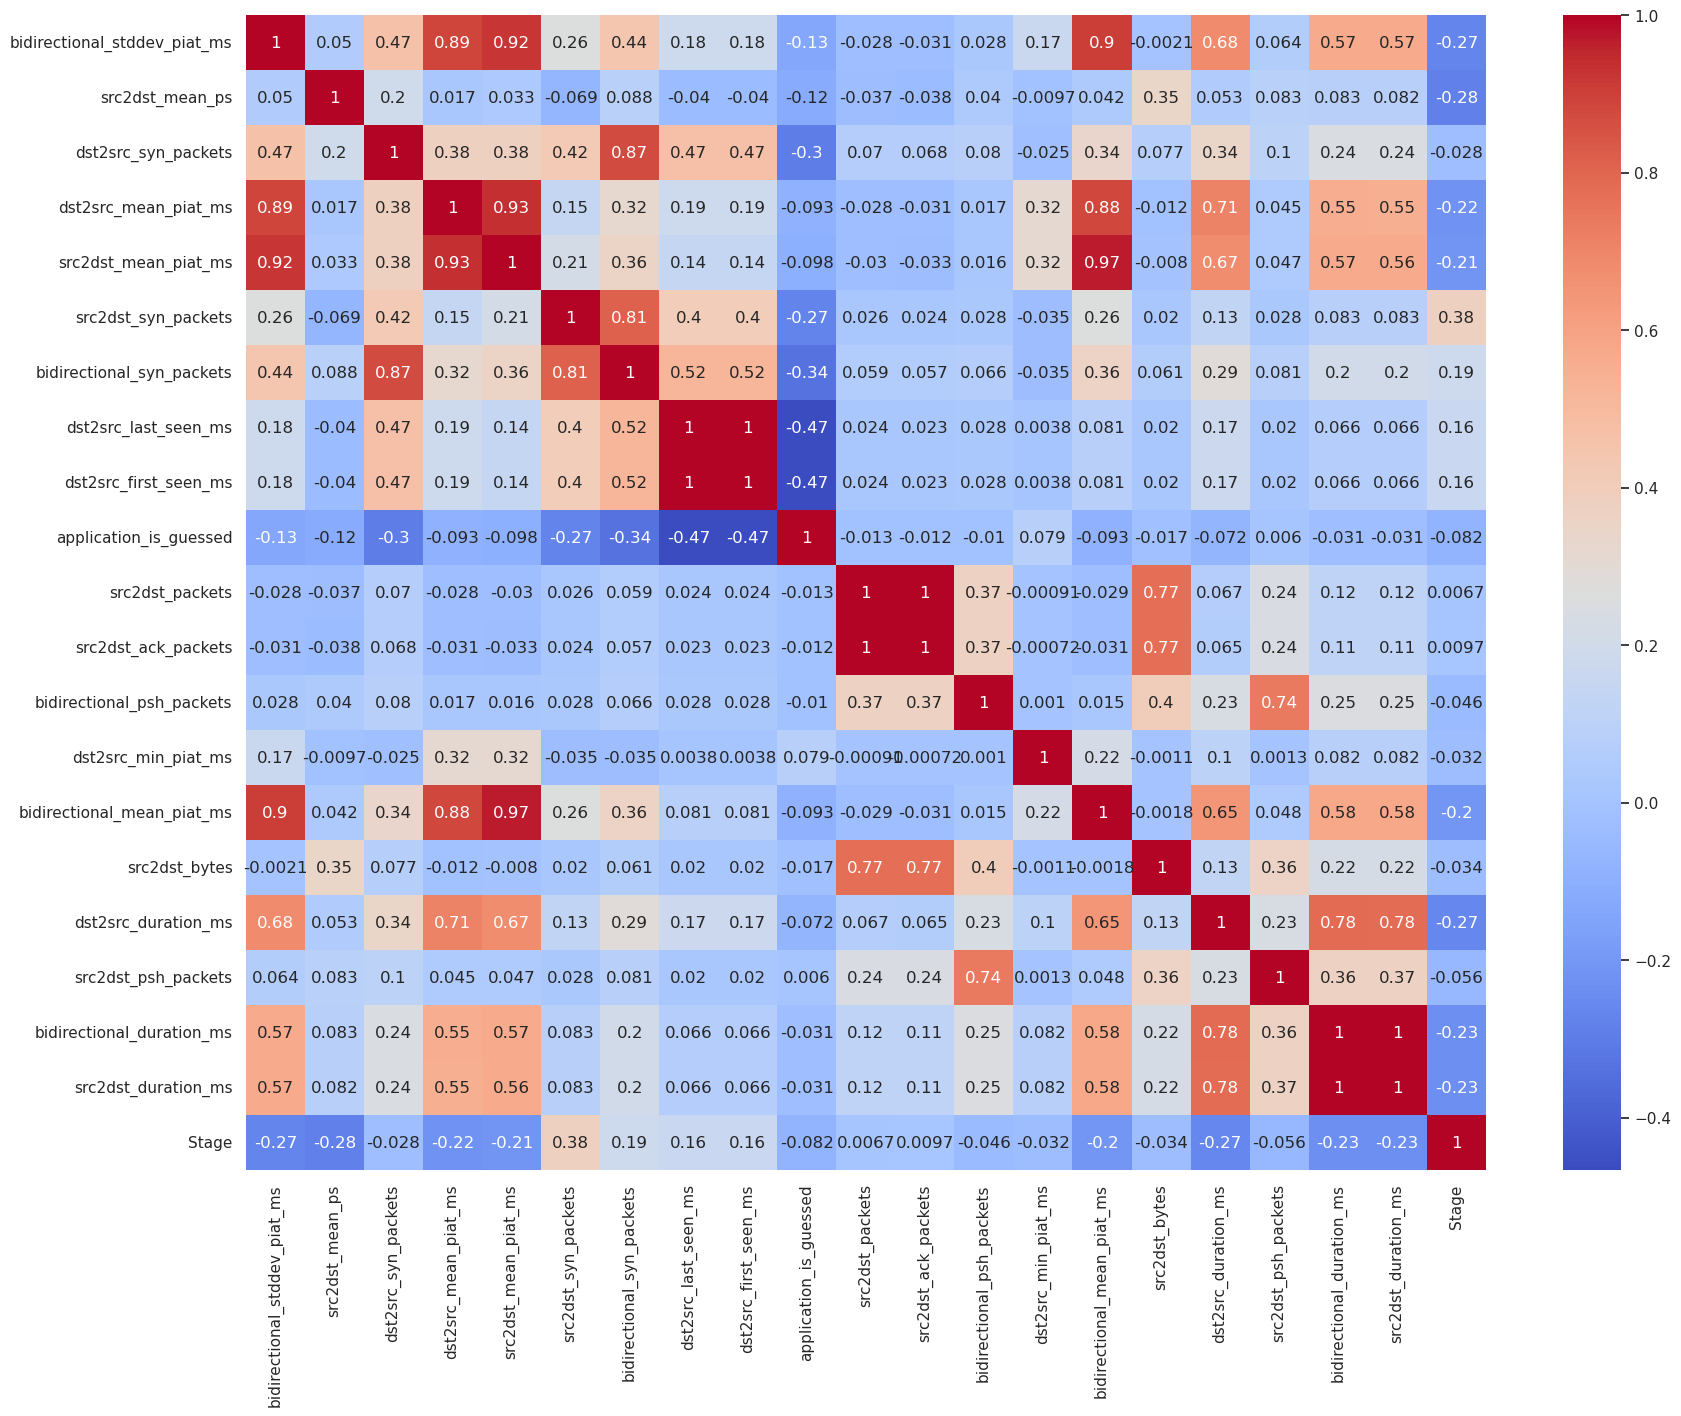

Zakończono proces.


In [182]:
from sklearn.preprocessing import LabelEncoder

print("Rozpoczynam proces...")

# przygotuj matryce korelacji dla całego df_d_pandas dla 20 najbardziej skorelowanych atrybutów
print("Wybieram 20 najbardziej skorelowanych atrybutów...")
top20 = pandas_df_d.head(20)
top20 = top20.sort_values(by=['correlation'], ascending=True)
# wez nazwy atrybutow
top20_features = top20['feature'].tolist()
# doklej Stage
top20_features.append('Stage')

# wyfiltruj z pysparka tylko te atrybuty i stage i przejdz do pandas
print("Filtruję dane...")
top20_df = df_d.select(*top20_features).toPandas()

# zmapuj Stage na liczby
print("Mapuję kolumnę 'Stage' na wartości liczbowe...")
le = LabelEncoder()
top20_df['Stage'] = le.fit_transform(top20_df['Stage'])

# policz korelacje
print("Obliczam macierz korelacji...")
corr = top20_df.corr()

# narysuj heatmap
print("Rysuję heatmap...")
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

print("Zakończono proces.")


<Figure size 2000x1500 with 0 Axes>

<Axes: >

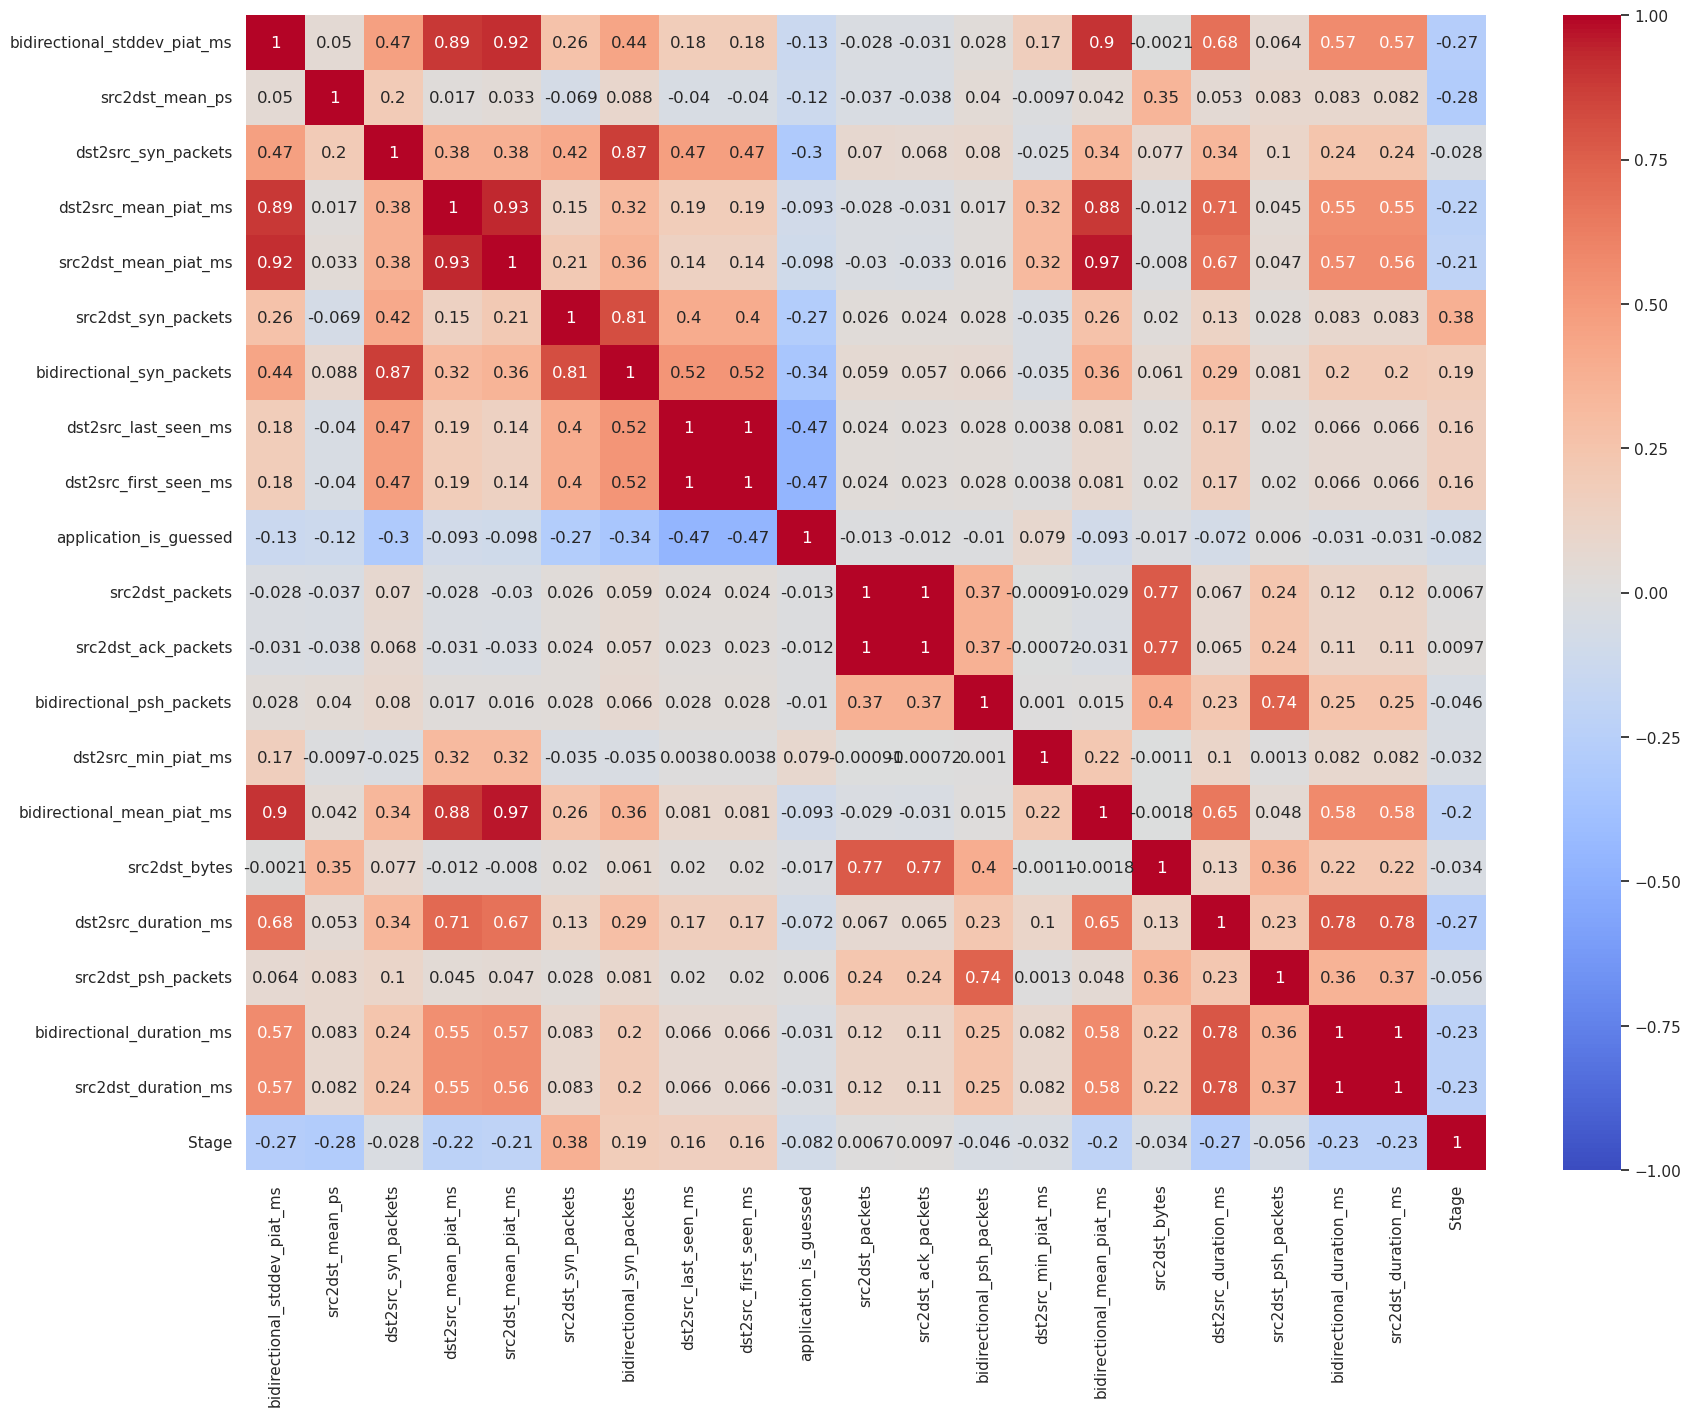

In [183]:
# zmien skale heatmapy na -1,1
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

/tmp/ipykernel_89683/558568914.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr1, dtype=np.bool)


<Figure size 2000x1500 with 0 Axes>

<Axes: >

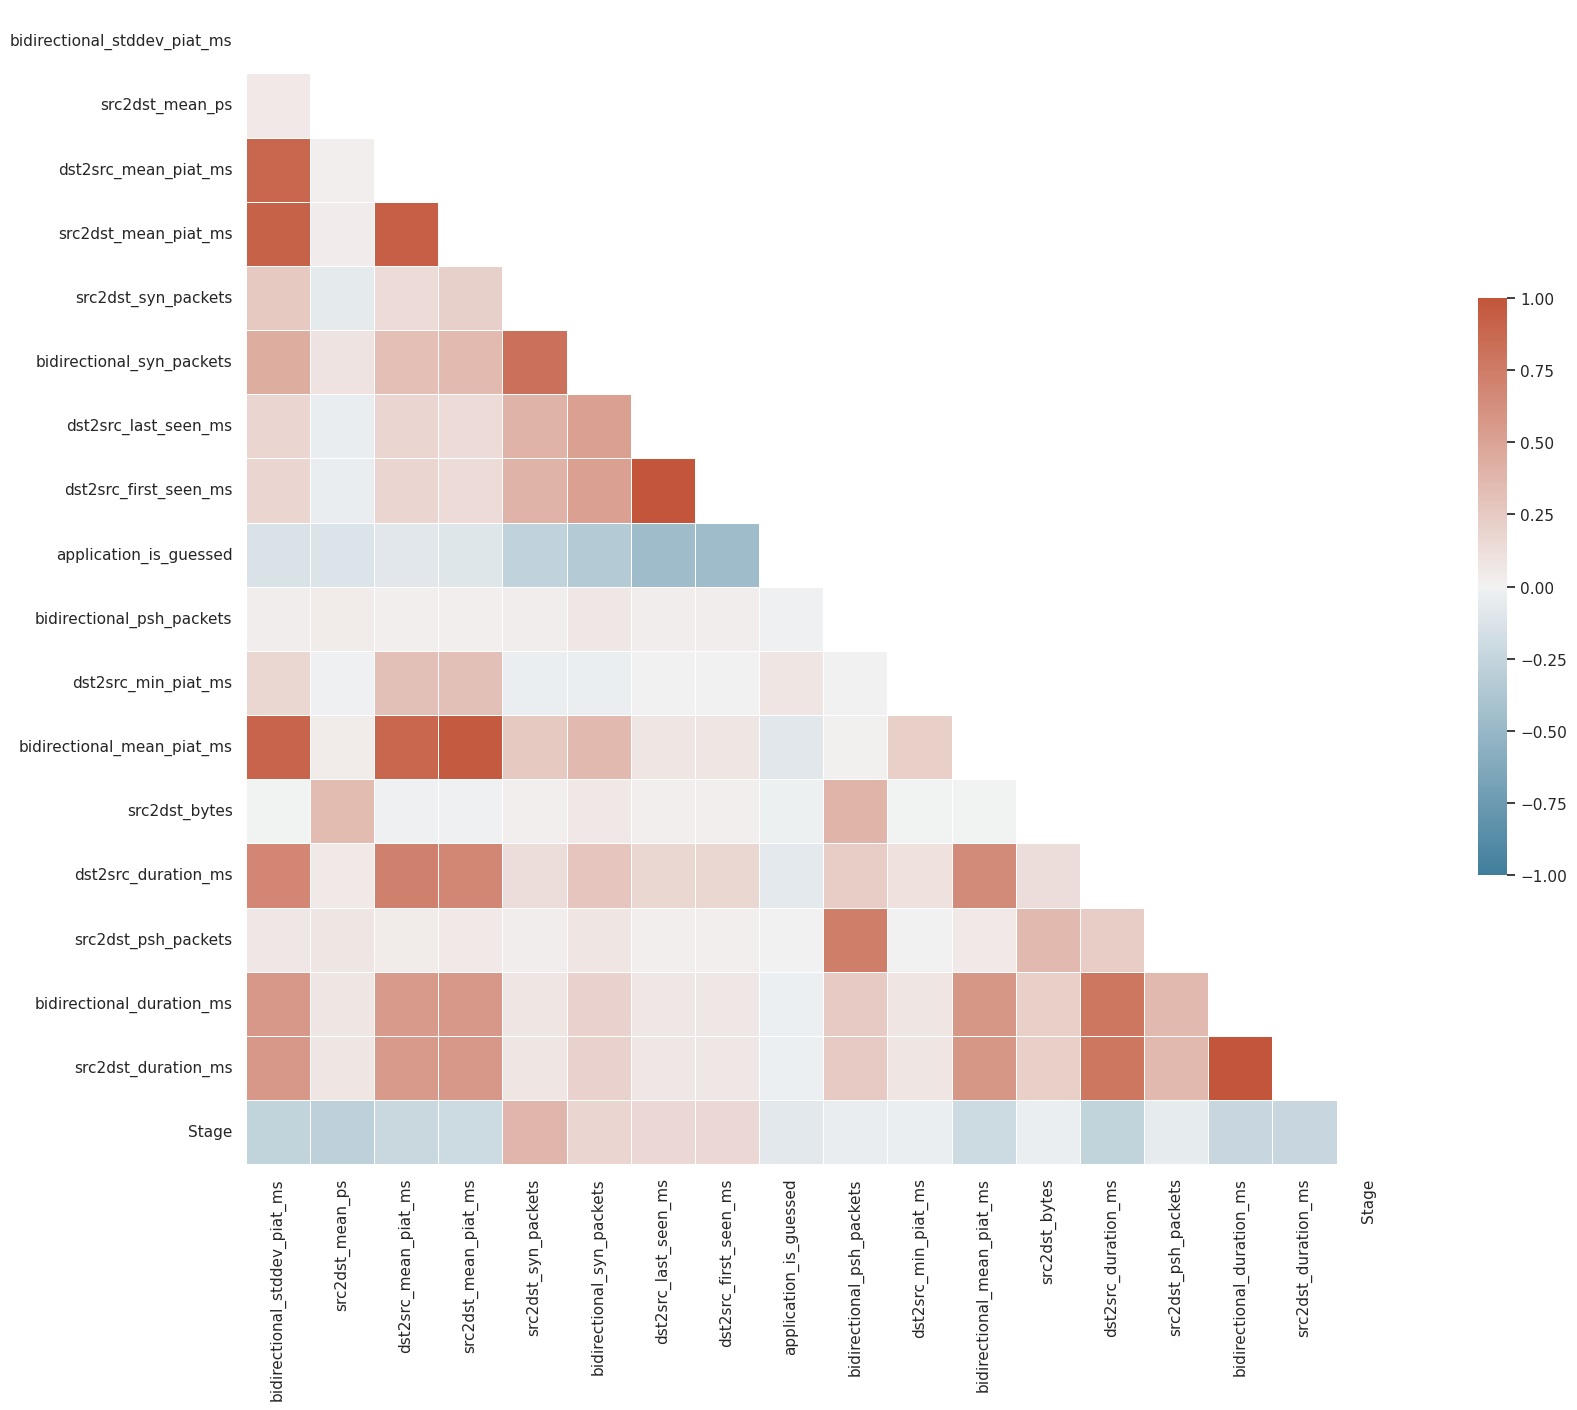

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# usuń z matrycy 4 najmniej skorelowane atrybuty (licząc wartość bezwględną)
corr1 = corr.drop(['src2dst_packets', 'src2dst_ack_packets', 'dst2src_syn_packets'], axis=1)
corr1 = corr1.drop(['src2dst_packets', 'src2dst_ack_packets', 'dst2src_syn_packets'], axis=0)

# Tworzymy maskę dla górnej połowy macierzy
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Ustawiamy tło wykresu na białe
sns.set_style("white")

# Tworzymy dużą figurę
plt.figure(figsize=(20,15))

# Rysujemy heatmapę z maską i właściwą paletą kolorów
cmap = sns.diverging_palette(230, 20, as_cmap=True) # generujemy paletę kolorów
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt='')

# Wyświetlamy wykres
plt.show()


### boxploty
src2dst_syn_packets, src2dst_psh_packets, dst2src_duration_ms, src2dst_bytes

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Stage', ylabel='src2dst_syn_packets'>

Text(0.5, 1.0, 'Boxplot of src2dst_syn_packets per Stage')

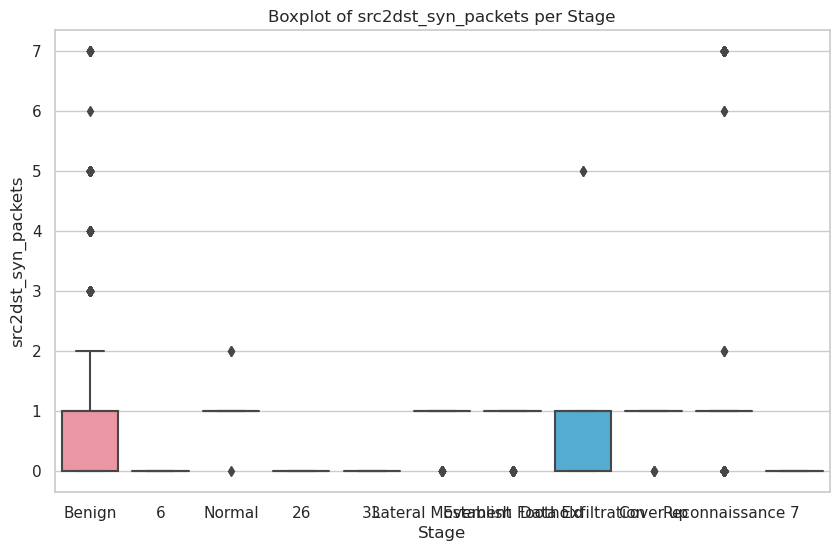

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

# Przekonwertuj dane do ramki pandas
df_pandas = df.select("Stage", "src2dst_syn_packets").toPandas()

# Ustawiamy styl wykresu
sns.set(style="whitegrid")

# Tworzymy boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x="Stage", y="src2dst_syn_packets", data=df_pandas)

# Ustawiamy tytuł wykresu
plt.title("Boxplot of src2dst_syn_packets per Stage")

# Wyświetlamy wykres
plt.show()


Text(0.5, 1.0, 'Boxplot of src2dst_syn_packets per Stage')

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

(0.0, 7.0)

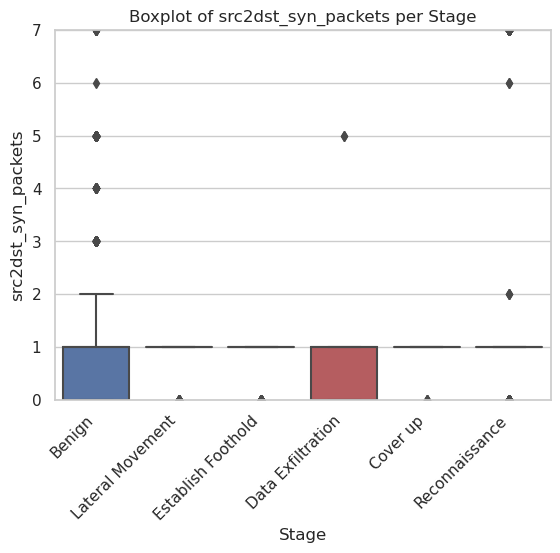

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51538)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
       ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
                  

In [247]:
# Zamień 'Normal' na 'Benign' w kolumnie 'Stage'
#df_pandas['Stage'] = df_pandas['Stage'].replace('Normal', 'Benign')

# Wyrzuć wartości numeryczne w kolumnie Stage
#df_pandas = df_pandas[df_pandas['Stage'].apply(lambda x: not x.isnumeric())]

# Ustawiamy styl wykresu
#sns.set(style="whitegrid")

# Tworzymy boxplot
#plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x="Stage", y="src2dst_syn_packets", data=df_pandas)

# Ustawiamy tytuł wykresu
plt.title("Boxplot of src2dst_syn_packets per Stage")

# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Przeskalowujemy os y
plt.ylim(0, 7)

# Wyświetlamy wykres
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Boxplot of src2dst_psh_packets per Stage')

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

(0.0, 1000.0)

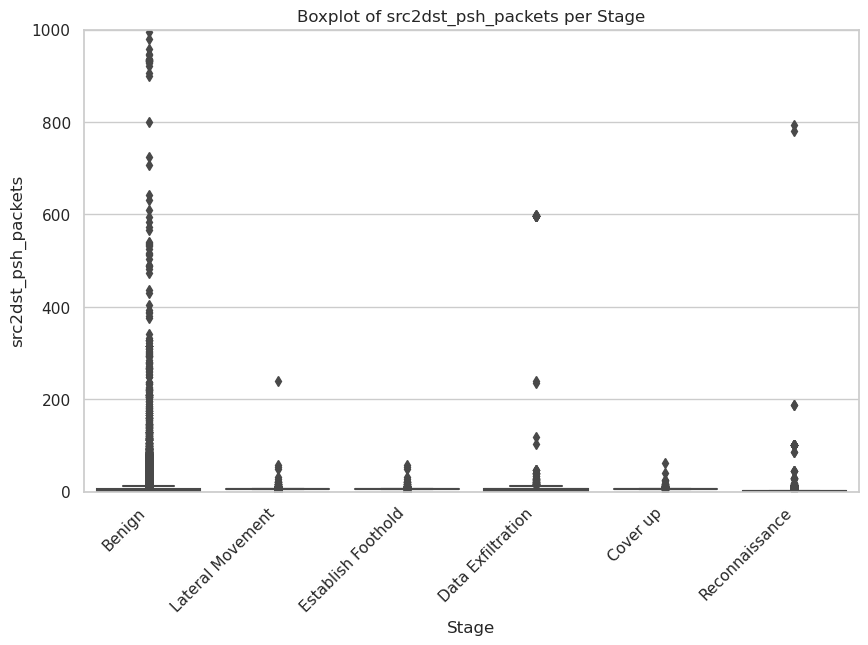

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

# Przekonwertuj dane do ramki pandas
#df1_pandas = df.select("Stage", "src2dst_psh_packets").toPandas()

# Zamień 'Normal' na 'Benign' w kolumnie 'Stage'
#df1_pandas['Stage'] = df1_pandas['Stage'].replace('Normal', 'Benign')

# Wyrzuć wartości numeryczne w kolumnie Stage
#df1_pandas = df1_pandas[df1_pandas['Stage'].apply(lambda x: not x.isnumeric())]

# Ustawiamy styl wykresu
#sns.set(style="whitegrid")

# Tworzymy boxplot
plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x="Stage", y="src2dst_psh_packets", data=df1_pandas)

# Ustawiamy tytuł wykresu
plt.title("Boxplot of src2dst_psh_packets per Stage")

# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Przeskalowujemy os y
plt.ylim(0, 1000)

# Wyświetlamy wykres
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Violinplot of src2dst_psh_packets per Stage')

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

(0.0, 25.0)

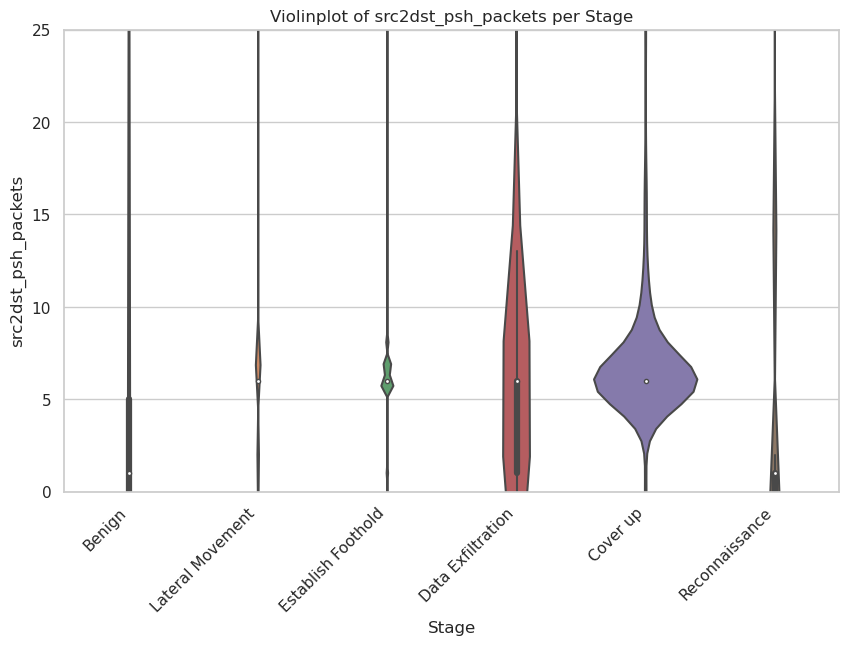

In [222]:
# Tworzymy violinplot
plt.figure(figsize=(10,6))
box_plot = sns.violinplot(x="Stage", y="src2dst_psh_packets", data=df1_pandas)

# Ustawiamy tytuł wykresu
plt.title("Violinplot of src2dst_psh_packets per Stage")

# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


# Przeskalowujemy os y
plt.ylim(0, 25)

# Wyświetlamy wykres
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Boxplot of dst2src_duration_ms per Stage')

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

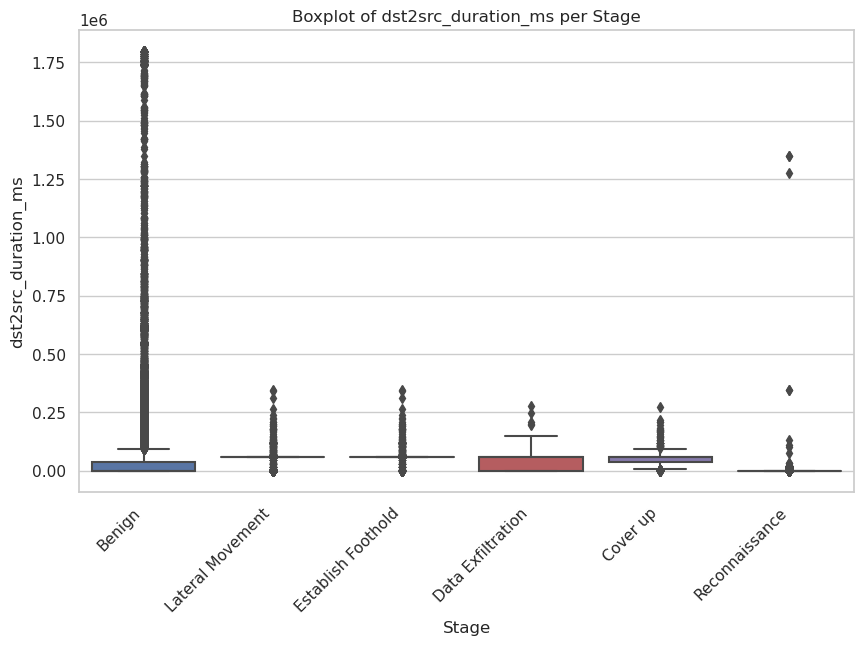

In [235]:

# Przekonwertuj dane do ramki pandas
#df2_pandas = df.select("Stage", "dst2src_duration_ms").toPandas()


# Zamień 'Normal' na 'Benign' w kolumnie 'Stage'
#df2_pandas['Stage'] = df2_pandas['Stage'].replace('Normal', 'Benign')

# Wyrzuć wartości numeryczne w kolumnie Stage
#df2_pandas = df2_pandas[df2_pandas['Stage'].apply(lambda x: not x.isnumeric())]


# Ustawiamy styl wykresu
sns.set(style="whitegrid")

# Tworzymy boxplot
plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x="Stage", y="dst2src_duration_ms", data=df2_pandas)

# Ustawiamy tytuł wykresu
plt.title("Boxplot of dst2src_duration_ms per Stage")


# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Wyświetlamy wykres
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Violinplot of dst2src_duration_ms per Stage')

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

(0.0, 100000.0)

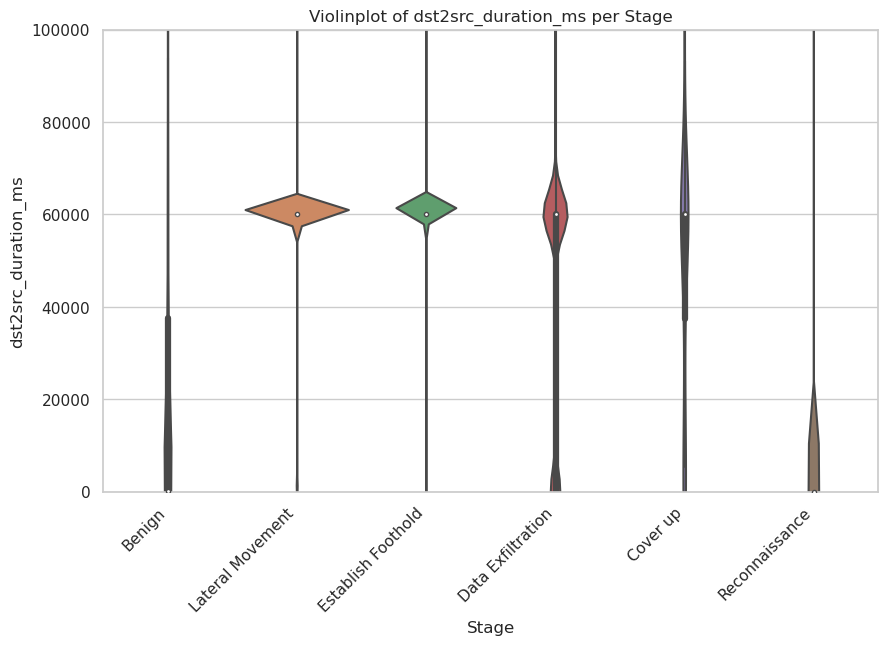

In [234]:
# Tworzymy boxplot violin!!!!!!!
plt.figure(figsize=(10,6))
box_plot = sns.violinplot(x="Stage", y="dst2src_duration_ms", data=df2_pandas)

# Ustawiamy tytuł wykresu
plt.title("Violinplot of dst2src_duration_ms per Stage")


# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


# Przeskalowujemy os y
plt.ylim(0, 100000)

# Wyświetlamy wykres
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Boxplot of src2dst_bytes per Stage')

(0.0, 6000000.0)

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

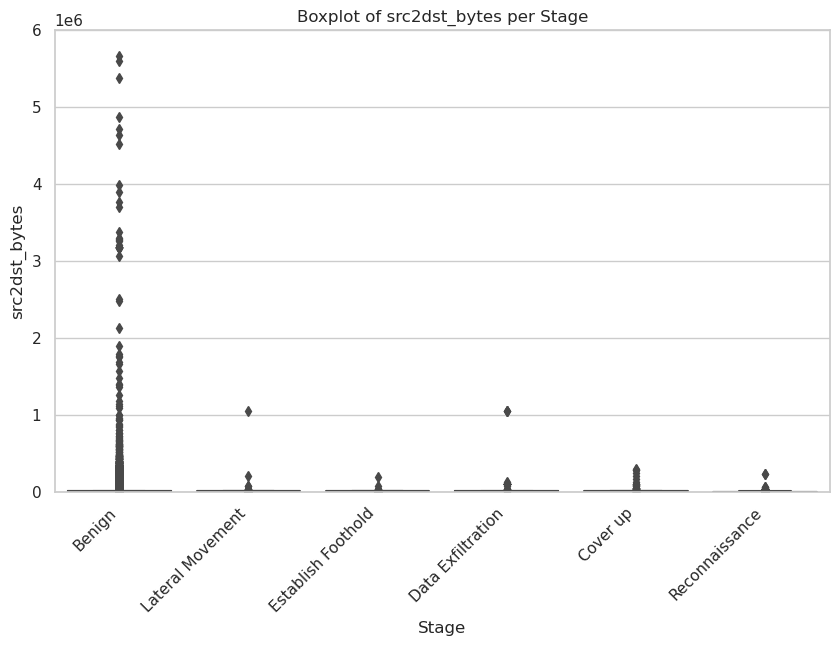

In [239]:

# Przekonwertuj dane do ramki pandas
#df3_pandas = df.select("Stage", "src2dst_bytes").toPandas()

# Zamień 'Normal' na 'Benign' w kolumnie 'Stage'
#df3_pandas['Stage'] = df3_pandas['Stage'].replace('Normal', 'Benign')

# Wyrzuć wartości numeryczne w kolumnie Stage
#df3_pandas = df3_pandas[df3_pandas['Stage'].apply(lambda x: not x.isnumeric())]

# Ustawiamy styl wykresu
sns.set(style="whitegrid")

# Tworzymy boxplot
plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x="Stage", y="src2dst_bytes", data=df3_pandas)

# Ustawiamy tytuł wykresu
plt.title("Boxplot of src2dst_bytes per Stage")

# Przeskalowujemy os y
plt.ylim(0, 6000000)


# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Wyświetlamy wykres
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Violinplot of src2dst_bytes per Stage')

(0.0, 35000.0)

[Text(0, 0, 'Benign'),
 Text(1, 0, 'Lateral Movement'),
 Text(2, 0, 'Establish Foothold'),
 Text(3, 0, 'Data Exfiltration'),
 Text(4, 0, 'Cover up'),
 Text(5, 0, 'Reconnaissance')]

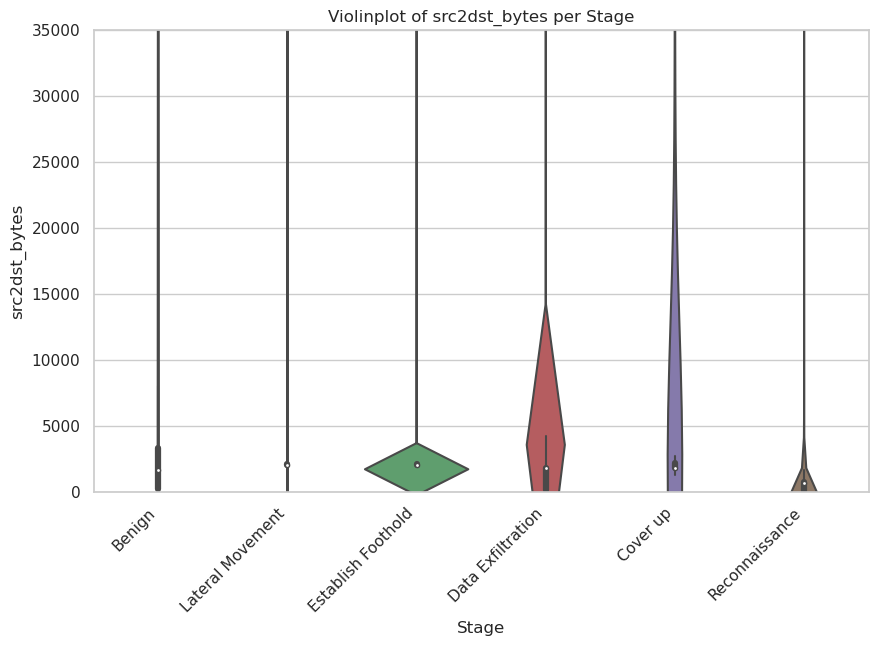

In [248]:
# Ustawiamy styl wykresu
sns.set(style="whitegrid")

# Tworzymy boxplot
plt.figure(figsize=(10,6))
box_plot = sns.violinplot(x="Stage", y="src2dst_bytes", data=df3_pandas)

# Ustawiamy tytuł wykresu
plt.title("Violinplot of src2dst_bytes per Stage")

# Przeskalowujemy os y
plt.ylim(0, 35000)


# Obracamy etykiety na osi x
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Wyświetlamy wykres
plt.show()

### 